In [1]:
# Importar las librerías necesarias
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  
from pathlib import Path
import glob
import time

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA  
from sklearn.cluster import KMeans



In [2]:
# Establecer el random seed
random_seed = 42
np.random.seed(random_seed)

# Cargar y Explorar los Datos
Carga el archivo parquet usando pandas y realiza una exploración inicial de los datos, incluyendo estadísticas descriptivas y visualización de distribuciones.

In [3]:
# Cargar todos los archivos parquet que contienen 'merged_inmuebles24_departamentos_duckdb'
data_folder = '../../data/processed/'
pattern = f"{data_folder}*merged_inmuebles24_departamentos_duckdb*.parquet"

In [4]:

# Buscar todos los archivos que coincidan con el patrón
files = glob.glob(pattern)


In [5]:

print(f"Archivos encontrados: {len(files)}")
for file in files:
    print(f"  - {Path(file).name}")


Archivos encontrados: 6
  - merged_inmuebles24_departamentos_duckdb_2025-10-11.parquet
  - merged_inmuebles24_departamentos_duckdb_2025-08-31.parquet
  - merged_inmuebles24_departamentos_duckdb_2025-09-27.parquet
  - merged_inmuebles24_departamentos_duckdb_2025-10-05.parquet
  - merged_inmuebles24_departamentos_duckdb_2025-09-14.parquet
  - merged_inmuebles24_departamentos_duckdb_2025-09-20.parquet


In [6]:

# Leer y concatenar todos los archivos
if len(files) == 0:
    raise FileNotFoundError(f"No se encontraron archivos con el patrón: {pattern}")


In [7]:

dfs = []
for file in files:
    temp_df = pd.read_parquet(file)
    temp_df['source_file'] = Path(file).name  # Agregar columna con nombre del archivo fuente
    dfs.append(temp_df)
    print(f"Cargado: {Path(file).name} - {len(temp_df)} registros")


Cargado: merged_inmuebles24_departamentos_duckdb_2025-10-11.parquet - 5975 registros
Cargado: merged_inmuebles24_departamentos_duckdb_2025-08-31.parquet - 5858 registros
Cargado: merged_inmuebles24_departamentos_duckdb_2025-09-27.parquet - 5986 registros
Cargado: merged_inmuebles24_departamentos_duckdb_2025-10-05.parquet - 5843 registros
Cargado: merged_inmuebles24_departamentos_duckdb_2025-09-14.parquet - 6040 registros
Cargado: merged_inmuebles24_departamentos_duckdb_2025-09-20.parquet - 5684 registros


In [8]:
# Concatenar todos los DataFrames
df = pd.concat(dfs, ignore_index=True)

In [9]:
df.shape

(35386, 155)

### Análisis de duplicados

In [10]:
# Contar duplicados completos (todas las columnas)
duplicados_completos = df.duplicated().sum()
print(f"\n1. Duplicados completos (todas las columnas): {duplicados_completos}")
print(f"   Porcentaje: {(duplicados_completos/len(df)*100):.2f}%")



1. Duplicados completos (todas las columnas): 0
   Porcentaje: 0.00%


In [11]:
# Identificar columnas clave para duplicados (excluyendo source_file)
cols_clave = [col for col in df.columns if col != 'source_file']
cols_clave


['precio_mxn',
 'lote_m2',
 'recamaras',
 'baños',
 'estacionamiento',
 'es_amueblado',
 'es_penthouse',
 'direccion',
 'colonia',
 'cp',
 'municipio',
 'Título',
 'Enlace',
 'latitud',
 'longitud',
 'colonia_std',
 'ENTIDAD',
 'NOM_ENT',
 'MUN',
 'NOM_MUN',
 'LOC',
 'NOM_LOC',
 'AGEB',
 'MZA',
 'POBTOT',
 'POBFEM',
 'POBMAS',
 'P_0A2',
 'P_0A2_F',
 'P_0A2_M',
 'P_18YMAS',
 'P_18YMAS_F',
 'P_18YMAS_M',
 'P_3A5',
 'P_3A5_F',
 'P_3A5_M',
 'P_6A11',
 'P_6A11_F',
 'P_6A11_M',
 'P_8A14',
 'P_8A14_F',
 'P_8A14_M',
 'P_12A14',
 'P_12A14_F',
 'P_12A14_M',
 'P_15A17',
 'P_15A17_F',
 'P_15A17_M',
 'P_18A24',
 'P_18A24_F',
 'P_18A24_M',
 'P_15A49_F',
 'P_60YMAS',
 'P_60YMAS_F',
 'P_60YMAS_M',
 'POB65_MAS',
 'P18YM_PB',
 'P18YM_PB_F',
 'P18YM_PB_M',
 'TOTHOG',
 'HOGJEF_F',
 'HOGJEF_M',
 'POBHOG',
 'PHOGJEF_F',
 'PHOGJEF_M',
 'VIVTOT',
 'TVIVHAB',
 'TVIVPAR',
 'VIVPAR_HAB',
 'VIVPARH_CV',
 'TVIVPARHAB',
 'VIVPAR_DES',
 'VIVPAR_UT',
 'OCUPVIVPAR',
 'PROM_OCUP',
 'PRO_OCUP_C',
 'VPH_1DOR',
 'VPH_2YMA

In [12]:
# Duplicados por columnas clave
duplicados_clave = df.duplicated(subset=cols_clave).sum()
print(f"\n2. Duplicados por columnas clave (excluyendo source_file): {duplicados_clave}")
print(f"   Porcentaje: {(duplicados_clave/len(df)*100):.2f}%")



2. Duplicados por columnas clave (excluyendo source_file): 13951
   Porcentaje: 39.43%


In [13]:
# Si hay duplicados, mostrar ejemplos
if duplicados_clave > 0:
    print("\n3. Ejemplos de registros duplicados:")
    mask_duplicados = df.duplicated(subset=cols_clave, keep=False)
    ejemplos_duplicados = df[mask_duplicados].sort_values(by=cols_clave[:3]).head(10)
    display(ejemplos_duplicados[['precio_mxn', 'lote_m2', 'direccion', 'source_file'][:min(5, len(ejemplos_duplicados.columns))]])
    
    # Contar duplicados por archivo fuente
    print("\n4. Distribución de duplicados por archivo fuente:")
    duplicados_por_archivo = df[mask_duplicados].groupby('source_file').size().sort_values(ascending=False)
    print(duplicados_por_archivo)



3. Ejemplos de registros duplicados:


precio_mxn  lote_m2                                          direccion  \
12479      2900.0       30  jardin azaleas jardines de san lorenzo tezonco...   
25286      2900.0       30  jardin azaleas jardines de san lorenzo tezonco...   
31143      2900.0       30  jardin azaleas jardines de san lorenzo tezonco...   
1409       2950.0       12             calle tepexpan la candelaria  coyoacan   
7647       2950.0       12             calle tepexpan la candelaria  coyoacan   
13006      2950.0       12             calle tepexpan la candelaria  coyoacan   
18554      2950.0       12             calle tepexpan la candelaria  coyoacan   
24899      2950.0       12             calle tepexpan la candelaria  coyoacan   
31218      2950.0       12             calle tepexpan la candelaria  coyoacan   
1204       3000.0       16  sur gabriel ramos millan seccion bramadero  iz...   

                                             source_file  
12479  merged_inmuebles24_departamentos_duckdb_2025-0...  
25286  merged_inmuebles24_departamentos_duckdb_2025-0...  
31143  merged_inmuebles24_departamentos_duckdb_2025-0...  
1409   merged_inmuebles24_departamentos_duckdb_2025-1...  
7647   merged_inmuebles24_departamentos_duckdb_2025-0...  
13006  merged_inmuebles24_departamentos_duckdb_2025-0...  
18554  merged_inmuebles24_departamentos_duckdb_2025-1...  
24899  merged_inmuebles24_departamentos_duckdb_2025-0...  
31218  merged_inmuebles24_departamentos_duckdb_2025-0...  
1204   merged_inmuebles24_departamentos_duckdb_2025-1...


4. Distribución de duplicados por archivo fuente:
source_file
merged_inmuebles24_departamentos_duckdb_2025-09-20.parquet    3926
merged_inmuebles24_departamentos_duckdb_2025-09-27.parquet    3892
merged_inmuebles24_departamentos_duckdb_2025-09-14.parquet    3702
merged_inmuebles24_departamentos_duckdb_2025-10-05.parquet    3628
merged_inmuebles24_departamentos_duckdb_2025-10-11.parquet    3022
merged_inmuebles24_departamentos_duckdb_2025-08-31.parquet    2604
dtype: int64


In [14]:
# Eliminar duplicados si existen
if duplicados_clave > 0:
    print(f"\n5. Eliminando {duplicados_clave} duplicados...")
    df_original_len = len(df)
    df = df.drop_duplicates(subset=cols_clave, keep='first')
    print(f"   Registros antes: {df_original_len}")
    print(f"   Registros después: {len(df)}")
    print(f"   Registros eliminados: {df_original_len - len(df)}")


5. Eliminando 13951 duplicados...
   Registros antes: 35386
   Registros después: 21435
   Registros eliminados: 13951


### Análisis de Nulos

In [15]:
# Contar nulos por columna
nulos_por_columna = df.isnull().sum().sort_values(ascending=False)
porcentaje_nulos = (nulos_por_columna / len(df) * 100).round(2)

In [16]:
# Crear DataFrame de resumen
resumen_nulos = pd.DataFrame({
    'Valores_Nulos': nulos_por_columna,
    'Porcentaje': porcentaje_nulos,
    'Tipo_Dato': df.dtypes
})

In [17]:
# Filtrar solo columnas con nulos
resumen_nulos_con_datos = resumen_nulos[resumen_nulos['Valores_Nulos'] > 0]

print(f"\n1. Resumen general:")
print(f"   Total de columnas: {len(df.columns)}")
print(f"   Columnas con nulos: {len(resumen_nulos_con_datos)}")
print(f"   Columnas sin nulos: {len(df.columns) - len(resumen_nulos_con_datos)}")


1. Resumen general:
   Total de columnas: 155
   Columnas con nulos: 141
   Columnas sin nulos: 14


In [18]:
# Exploración inicial de los datos
# Mostrar las primeras filas del DataFrame
print("Primeras filas del DataFrame:")
df.head()


Primeras filas del DataFrame:


precio_mxn  lote_m2  recamaras  baños  estacionamiento  es_amueblado  \
0     18000.0      130        2.0    1.0              1.0             0   
1     30000.0      198        2.0    2.0              2.0             0   
2     23500.0      110        2.0    2.0              1.0             1   
3     14000.0       59        2.0    1.0              1.0             0   
4     14000.0       30        1.0    1.0              1.0             1   

   es_penthouse                                          direccion  \
0             0         rio becerra 135 8 de agosto  benito juarez   
1             0     avenida rio mixcoac 206 acacias  benito juarez   
2             0  av. san francisco  col. del valle actipan  ben...   
3             0              calle 2 agricola pantitlan  iztacalco   
4             0  av. tamaulipas 257 alvaro obregon  ciudad de m...   

              colonia    cp  ...  \
0         8 de agosto  1180  ...   
1             acacias  3240  ...   
2             actipan  3230  ...   
3  agricola pantitlan  8100  ...   
4      alvaro obregon  9230  ...   

                                             address  \
0  {'road': 'Calle Martell', 'neighbourhood': 'Co...   
1  {'road': 'Calle 1', 'neighbourhood': 'Colonia ...   
2  {'road': 'José María Rico', 'neighbourhood': '...   
3  {'house_number': '116', 'road': 'Calle 2', 'ne...   
4  {'road': 'Avenida Congreso de la Unión', 'neig...   

                           road quarter              borough  postcode  \
0                 Calle Martell    None       Álvaro Obregón     01180   
1                       Calle 1    None        Benito Juárez     03240   
2               José María Rico    None        Benito Juárez     03240   
3                       Calle 2    None            Iztacalco     08100   
4  Avenida Congreso de la Unión    None  Venustiano Carranza     15990   

  longitud_1  latitud_1       neighbourhood distancia  \
0 -99.189077  19.394770         8 de agosto  0.008476   
1 -99.175132  19.363520             acacias  0.000234   
2 -99.176422  19.368233             actipan  0.000330   
3 -99.067143  19.409103  agricola pantitlan  0.000125   
4 -99.121470  19.412086      alvaro obregon  0.153109   

                                         source_file  
0  merged_inmuebles24_departamentos_duckdb_2025-1...  
1  merged_inmuebles24_departamentos_duckdb_2025-1...  
2  merged_inmuebles24_departamentos_duckdb_2025-1...  
3  merged_inmuebles24_departamentos_duckdb_2025-1...  
4  merged_inmuebles24_departamentos_duckdb_2025-1...  

[5 rows x 155 columns]

In [19]:
if len(resumen_nulos_con_datos) > 0:
    print(f"\n2. Top 20 columnas con más valores nulos:")
    display(resumen_nulos_con_datos.head(20))
    


2. Top 20 columnas con más valores nulos:


Valores_Nulos  Porcentaje Tipo_Dato
AGEB                 1892        8.83    object
AGEB_fm              1892        8.83    object
CVEFT                1892        8.83    object
CVEREF1              1892        8.83    object
CVEREF2              1892        8.83    object
CVEREF3              1892        8.83    object
CVESEG               1892        8.83    object
CVESEG1              1892        8.83    object
CVESEG2              1892        8.83    object
CVESEG3              2183       10.18    object
CVEVIAL              1892        8.83    object
CVEVIAL1             1892        8.83    object
CVEVIAL2             1892        8.83    object
CVEVIAL3             2183       10.18    object
ENTIDAD              1892        8.83    object
ENTIDAD_fm           1892        8.83    object
HOGJEF_F             1892        8.83    object
HOGJEF_M             1892        8.83    object
LOC                  1892        8.83    object
LOC_fm               1892        8.83    object

In [20]:
df[df.AGEB.isnull()].head(10)

precio_mxn  lote_m2  recamaras  baños  estacionamiento  es_amueblado  \
5238     15000.0       63        1.0    1.0              2.0             0   
5239     16000.0       80        3.0    2.0              1.0             1   
5240     26000.0      161        2.0    2.0              2.0             0   
5241     10000.0       15        1.0    1.0              1.0             1   
5242     22000.0       80        3.0    2.0              2.0             0   
5243     16000.0      100        4.0    1.0              1.0             0   
5244     85000.0      325        3.0    3.0              2.0             0   
5245     45000.0      125        2.0    2.0              0.0             0   
5246     45000.0      125        2.0    2.0              0.0             0   
5247    175000.0      345        2.0    2.0              2.0             1   

      es_penthouse                                          direccion  \
5238             0  cerrada de escuela superior de guerra 81 san j...   
5239             0  privada escuela superior de guerra san jeronim...   
5240             0  av. conteras 643 san jeronimo lidice  la magda...   
5241             0  privada de antonia san jeronimo lidice  la mag...   
5242             0  270 av mexico contreras san jeronimo lidice  l...   
5243             0           av. tlahuac pueblo culhuacan  iztapalapa   
5244             0  avenida emilio castelar polanco iv seccion  po...   
5245             0    av. emilio castelar polanco iv seccion  polanco   
5246             0  avenida emilio castelar polanco iv seccion  po...   
5247             0                  solon polanco ii seccion  polanco   

                  colonia     cp  ... address  road quarter  borough  \
5238  san jeronimo lidice  10200  ...    None  None    None     None   
5239  san jeronimo lidice  10200  ...    None  None    None     None   
5240  san jeronimo lidice  10200  ...    None  None    None     None   
5241  san jeronimo lidice  10200  ...    None  None    None     None   
5242  san jeronimo lidice  10200  ...    None  None    None     None   
5243            culhuacan   9800  ...    None  None    None     None   
5244   polanco iv seccion  11550  ...    None  None    None     None   
5245   polanco iv seccion  11550  ...    None  None    None     None   
5246   polanco iv seccion  11550  ...    None  None    None     None   
5247   polanco ii seccion  11530  ...    None  None    None     None   

      postcode longitud_1 latitud_1 neighbourhood distancia  \
5238      None        NaN       NaN          None       NaN   
5239      None        NaN       NaN          None       NaN   
5240      None        NaN       NaN          None       NaN   
5241      None        NaN       NaN          None       NaN   
5242      None        NaN       NaN          None       NaN   
5243      None        NaN       NaN          None       NaN   
5244      None        NaN       NaN          None       NaN   
5245      None        NaN       NaN          None       NaN   
5246      None        NaN       NaN          None       NaN   
5247      None        NaN       NaN          None       NaN   

                                            source_file  
5238  merged_inmuebles24_departamentos_duckdb_2025-1...  
5239  merged_inmuebles24_departamentos_duckdb_2025-1...  
5240  merged_inmuebles24_departamentos_duckdb_2025-1...  
5241  merged_inmuebles24_departamentos_duckdb_2025-1...  
5242  merged_inmuebles24_departamentos_duckdb_2025-1...  
5243  merged_inmuebles24_departamentos_duckdb_2025-1...  
5244  merged_inmuebles24_departamentos_duckdb_2025-1...  
5245  merged_inmuebles24_departamentos_duckdb_2025-1...  
5246  merged_inmuebles24_departamentos_duckdb_2025-1...  
5247  merged_inmuebles24_departamentos_duckdb_2025-1...  

[10 rows x 155 columns]

In [21]:
df = df.dropna(subset=['AGEB'])

In [22]:
df.shape

(19543, 155)

In [23]:
df.isnull().sum().sort_values(ascending=False)

quarter        19494
longitud        7498
latitud         7498
distancia       7498
TIPOVR3          291
               ...  
P_60YMAS_F         0
P_60YMAS_M         0
POB65_MAS          0
P18YM_PB           0
source_file        0
Length: 155, dtype: int64

In [24]:
df = df.drop_duplicates(subset=['Título'])

In [25]:
df = df.dropna(subset=['latitud', 'longitud'])

In [26]:
df.shape

(8291, 155)

In [27]:
df.isnull().sum().sort_values(ascending=False)[:20]

quarter       8262
CVEVIAL3       117
CVESEG3        117
TIPOVR3        117
NOMREF3        117
road            87
lote_m2         51
VPH_BICI         0
VPH_REFRI        0
VPH_LAVAD        0
VPH_HMICRO       0
VPH_AUTOM        0
VPH_MOTO         0
VPH_RADIO        0
VPH_NDACMM       0
VPH_TV           0
VPH_PC           0
VPH_TELEF        0
VPH_CEL          0
VPH_INTER        0
dtype: int64

In [28]:
obj_cols = ['direccion','colonia','cp','neighbourhood','Título','Enlace','colonia_std','municipio',
            'ENTIDAD', 'NOM_ENT', 'MUN', 'NOM_MUN', 'LOC', 'NOM_LOC', 'AGEB', 'MZA',
            'key', 'ENTIDAD_fm', 'MUN_fm', 'LOC_fm', 'AGEB_fm',
            'MZA_fm', 'CVEVIAL', 'CVESEG', 'CVEFT', 'NOMVIAL', 'TIPOVIAL',
            'CVEVIAL1', 'CVESEG1', 'CVEREF1', 'TIPOVR1', 'NOMREF1', 'CVEVIAL2',
            'CVESEG2', 'CVEREF2', 'TIPOVR2', 'NOMREF2', 'CVEVIAL3', 'CVESEG3',
            'CVEREF3', 'TIPOVR3', 'NOMREF3', 'municipio_1', 'address', 'road',
            'quarter', 'borough', 'postcode', 'neighbourhood', 'source_file', 
            'lon', 'lat','latitud_1', 'longitud_1','distancia','latitud','longitud']

In [29]:
target = ['precio_mxn']

In [30]:
numeric_cols = list(set(df.columns) - set(obj_cols) - set(target))

In [31]:
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

In [32]:
uppercase_columns = [col for col in df[numeric_cols].columns if col.isupper()]
print("Columns with uppercase names:", uppercase_columns)

Columns with uppercase names: ['TVIVHAB', 'P_60YMAS', 'P_18YMAS', 'VPH_TINACO', 'VPH_CEL', 'VIVPAR_HAB', 'VPH_NDEAED', 'P_6A11_M', 'POB65_MAS', 'P_3A5_F', 'P18YM_PB_M', 'PHOGJEF_M', 'VIVPARH_CV', 'P_18A24', 'P_18YMAS_F', 'VPH_SINLTC', 'VPH_AGUAFV', 'P_8A14_M', 'P_12A14_M', 'VPH_REFRI', 'P_3A5_M', 'VPH_SINCINT', 'VPH_HMICRO', 'PHOGJEF_F', 'VPH_NDACMM', 'POBHOG', 'P18YM_PB_F', 'VPH_DSADMA', 'VPH_NODREN', 'VPH_LETR', 'VIVPAR_DES', 'VPH_3YMASC', 'PROM_OCUP', 'VPH_SPMVPI', 'POBFEM', 'VPH_AEASP', 'VIVTOT', 'P_60YMAS_M', 'P_6A11', 'P_18A24_F', 'TVIVPAR', 'VPH_CVJ', 'P_60YMAS_F', 'OCUPVIVPAR', 'VPH_AGUADV', 'VPH_CISTER', 'VPH_2YMASD', 'P_0A2', 'VPH_SINRTV', 'PRO_OCUP_C', 'P_6A11_F', 'P_0A2_F', 'P_15A17_F', 'HOGJEF_F', 'P_15A17', 'HOGJEF_M', 'VPH_DRENAJ', 'VPH_SINTIC', 'VPH_1DOR', 'VPH_EXCSA', 'VPH_C_ELEC', 'POBTOT', 'P_8A14', 'VPH_PC', 'P_0A2_M', 'VPH_BICI', 'P_3A5', 'VPH_RADIO', 'VPH_TELEF', 'P18YM_PB', 'VPH_C_SERV', 'VPH_STVP', 'P_15A17_M', 'P_15A49_F', 'VPH_SNBIEN', 'TVIVPARHAB', 'VPH_INTER

In [33]:
#porque sabemos de los datos del INEGI que no hay registros.
df[uppercase_columns] = df[uppercase_columns].fillna(0)

In [34]:
df.isnull().sum().sort_values(ascending=False)[:10]

quarter      8262
CVEVIAL3      117
CVESEG3       117
TIPOVR3       117
NOMREF3       117
road           87
lote_m2        51
VPH_BICI        0
VPH_REFRI       0
VPH_LAVAD       0
dtype: int64

In [35]:
df['lote_m2'] = df.groupby('colonia')['lote_m2'].transform(lambda x: x.fillna(int(x.mean())))

In [36]:
df[df['lote_m2'].isnull()].source_file.value_counts()

Series([], Name: count, dtype: int64)

In [37]:
# Información general del DataFrame
print("\nInformación general del DataFrame:")
df.info()


Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 8291 entries, 0 to 33886
Columns: 155 entries, precio_mxn to source_file
dtypes: Int64(1), float64(100), int64(5), object(49)
memory usage: 9.9+ MB


In [38]:
fix_int = list(df.select_dtypes('Int64').columns)

In [39]:
fix_int

['lote_m2', 'es_amueblado', 'es_penthouse', 'POBTOT', 'VIVTOT', 'TVIVHAB']

In [40]:
df[fix_int] = df[fix_int].astype('int64')

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8291 entries, 0 to 33886
Columns: 155 entries, precio_mxn to source_file
dtypes: float64(100), int64(6), object(49)
memory usage: 9.9+ MB


In [42]:
# Estadísticas descriptivas
print("\nEstadísticas descriptivas:")
df.describe(include='all')


Estadísticas descriptivas:


precio_mxn        lote_m2    recamaras        baños  \
count     8291.000000    8291.000000  8291.000000  8291.000000   
unique            NaN            NaN          NaN          NaN   
top               NaN            NaN          NaN          NaN   
freq              NaN            NaN          NaN          NaN   
mean     37221.490040     280.645640     1.983717     1.753829   
std      29561.065994   10512.204463     0.902269     0.792803   
min         12.000000       1.000000     0.000000     0.000000   
25%      19518.000000      64.000000     1.000000     1.000000   
50%      29000.000000      90.000000     2.000000     2.000000   
75%      43000.000000     140.000000     2.000000     2.000000   
max     447840.000000  860000.000000    30.000000    12.000000   

        estacionamiento  es_amueblado  es_penthouse  \
count       8291.000000   8291.000000   8291.000000   
unique              NaN           NaN           NaN   
top                 NaN           NaN           NaN   
freq                NaN           NaN           NaN   
mean           1.348330      0.294898      0.041370   
std            0.881524      0.456024      0.199157   
min            0.000000      0.000000      0.000000   
25%            1.000000      0.000000      0.000000   
50%            1.000000      0.000000      0.000000   
75%            2.000000      1.000000      0.000000   
max           22.000000      1.000000      1.000000   

                              direccion  colonia    cp  ...  \
count                              8291     8291  8291  ...   
unique                             4529      294   269  ...   
top     polanco polanco  miguel hidalgo  hidalgo  1120  ...   
freq                                 93     2518  2529  ...   
mean                                NaN      NaN   NaN  ...   
std                                 NaN      NaN   NaN  ...   
min                                 NaN      NaN   NaN  ...   
25%                                 NaN      NaN   NaN  ...   
50%                                 NaN      NaN   NaN  ...   
75%                                 NaN      NaN   NaN  ...   
max                                 NaN      NaN   NaN  ...   

                                                  address        road  \
count                                                8291        8204   
unique                                               1183         801   
top     {'amenity': 'Colegio Americano', 'road': 'Call...  Calle Tula   
freq                                                 2283        2283   
mean                                                  NaN         NaN   
std                                                   NaN         NaN   
min                                                   NaN         NaN   
25%                                                   NaN         NaN   
50%                                                   NaN         NaN   
75%                                                   NaN         NaN   
max                                                   NaN         NaN   

           quarter         borough  postcode   longitud_1    latitud_1  \
count           29            8291      8291  8291.000000  8291.000000   
unique           4              15       305          NaN          NaN   
top     Tlatelolco  Álvaro Obregón     01120          NaN          NaN   
freq            16            3508      2526          NaN          NaN   
mean           NaN             NaN       NaN   -99.188927    19.397808   
std            NaN             NaN       NaN     0.041907     0.033693   
min            NaN             NaN       NaN   -99.304810    19.206014   
25%            NaN             NaN       NaN   -99.206255    19.376291   
50%            NaN             NaN       NaN   -99.182552    19.400303   
75%            NaN             NaN       NaN   -99.163803    19.423057   
max            NaN             NaN       NaN   -99.008577    19.517450   

       neighbourhood    distancia 

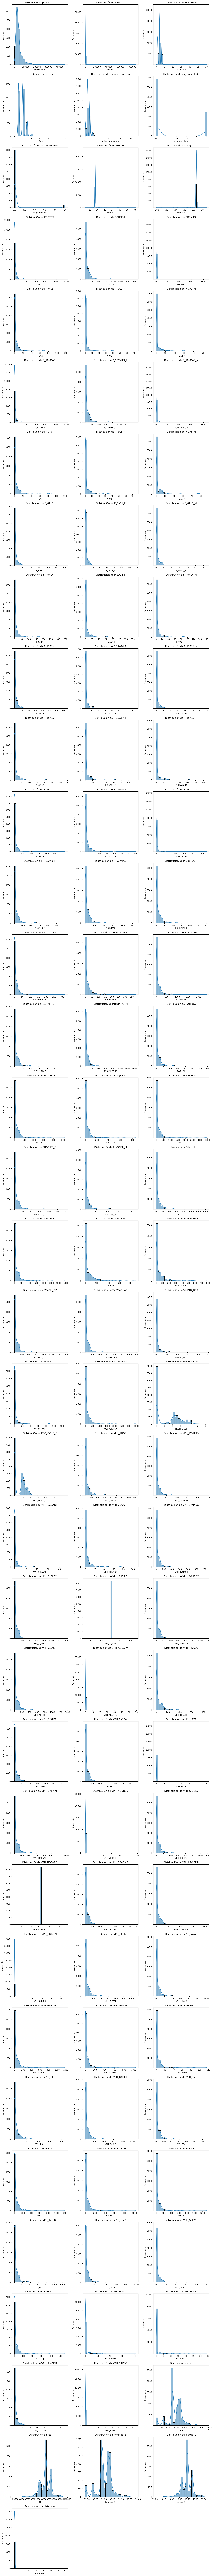

In [43]:
# Visualización de distribuciones
# Seleccionar columnas numéricas
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Crear subplots para las columnas numéricas
num_cols = len(numeric_columns)
fig, axes = plt.subplots(nrows=(num_cols // 3) + 1, ncols=3, figsize=(15, 5 * ((num_cols // 3) + 1)))
axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    sns.histplot(df[column], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f"Distribución de {column}")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Frecuencia")

# Eliminar ejes vacíos si hay menos subplots que espacios
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

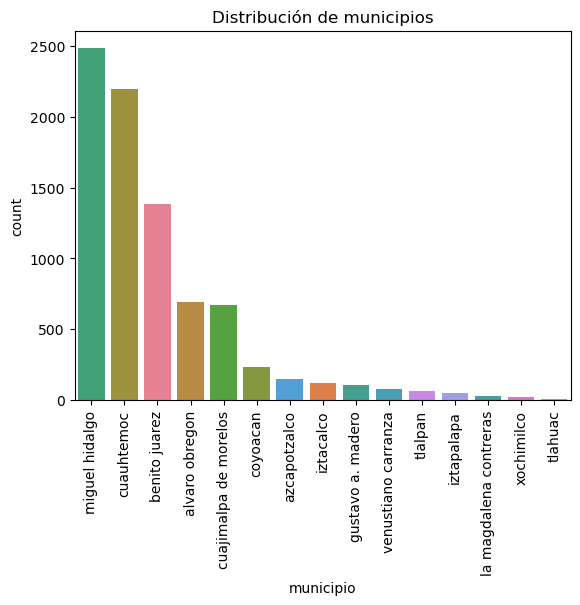

In [44]:
municipio_order = df['municipio'].value_counts().index

sns.countplot(data=df, x='municipio', order=municipio_order, hue='municipio')
plt.xticks(rotation=90)
plt.title('Distribución de municipios')
plt.show()

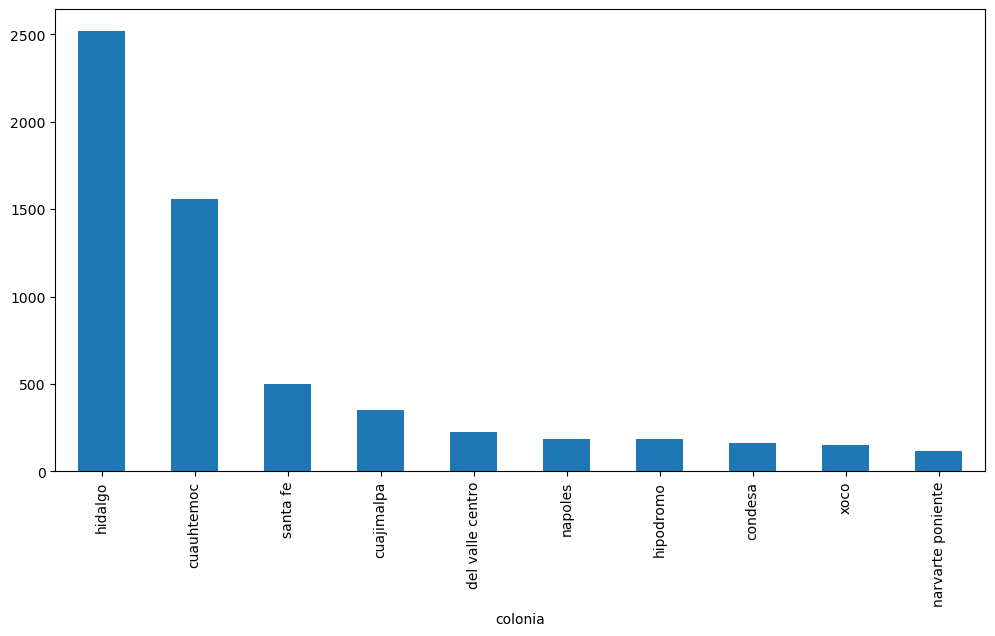

In [45]:
df.colonia.value_counts().head(10).plot(kind='bar', figsize=(12,6))
plt.show()

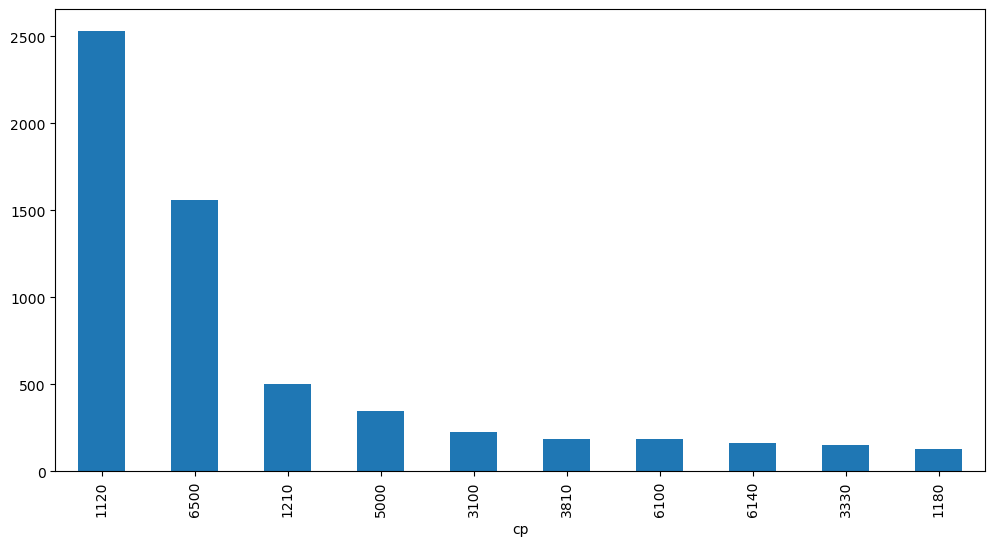

In [46]:
# Un CP puede contener varias colonias, así que nos quedamos sólo con colonias
df.cp.value_counts().head(10).plot(kind='bar', figsize=(12,6))
plt.show()

In [47]:
top10_cols= list(df.colonia.value_counts().head(10).index)

In [48]:
df['colonia_top10'] = df['colonia'].where(df['colonia'].isin(top10_cols), 'otros')

/var/folders/c7/mdvpp7_n2dj49y88d6cj51kc0000gn/T/ipykernel_16382/2711523768.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['colonia_top10'] = df['colonia'].where(df['colonia'].isin(top10_cols), 'otros')


# Preprocesamiento de Datos
Aplica técnicas de limpieza de datos, manejo de valores nulos y codificación de variables categóricas.

In [49]:
# Identificar valores nulos en el DataFrame
print("\nValores nulos por columna:")
df.isnull().sum().sort_values(ascending=False)


Valores nulos por columna:


quarter          8262
CVEVIAL3          117
CVESEG3           117
TIPOVR3           117
NOMREF3           117
                 ... 
P_60YMAS            0
P_60YMAS_F          0
P_60YMAS_M          0
POB65_MAS           0
colonia_top10       0
Length: 156, dtype: int64

In [50]:
# outliers
# Función para detectar outliers usando el método del rango intercuartílico (IQR) 
def detectar_outliers_iqr(data, columna):
    Q1 = data[columna].quantile(0.25)
    Q3 = data[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = data[(data[columna] < limite_inferior) | (data[columna] > limite_superior)]
    return outliers


Número de outliers en TVIVHAB: 556
    TVIVHAB
1       234
2       220
10      176
17      215
66      315

Número de outliers en P_60YMAS: 616
    P_60YMAS
1      104.0
2      137.0
10      84.0
49      78.0
66     161.0

Número de outliers en P_18YMAS: 543
    P_18YMAS
1      482.0
2      456.0
10     453.0
66     856.0
67     488.0

Número de outliers en VPH_TINACO: 543
    VPH_TINACO
1        162.0
2        207.0
10       165.0
17       215.0
66       273.0

Número de outliers en VPH_CEL: 561
    VPH_CEL
1     230.0
2     215.0
10    168.0
17    215.0
66    286.0

Número de outliers en VIVPAR_HAB: 491
    VIVPAR_HAB
1        223.0
2        220.0
10       176.0
17       213.0
66       315.0

Número de outliers en VPH_NDEAED: 0

Número de outliers en P_6A11_M: 1149
    P_6A11_M
1        9.0
2        9.0
3       10.0
10      13.0
12      16.0

Número de outliers en POB65_MAS: 585
    POB65_MAS
1        75.0
2        97.0
49       66.0
66       99.0
67       65.0

Número de outliers e

/var/folders/c7/mdvpp7_n2dj49y88d6cj51kc0000gn/T/ipykernel_16382/2478390224.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 4))



Número de outliers en P18YM_PB_F: 532
    P18YM_PB_F
1        248.0
2        221.0
10       156.0
51       154.0
66       261.0

Número de outliers en VPH_DSADMA: 548
    VPH_DSADMA
1        234.0
2        220.0
10       176.0
17       215.0
66       315.0

Número de outliers en VPH_NODREN: 15
      VPH_NODREN
863         29.0
912          5.0
1124         6.0
1301         5.0
2064        29.0

Número de outliers en VPH_LETR: 22
      VPH_LETR
682        4.0
912        6.0
1332       4.0
1666       4.0
1667       4.0

Número de outliers en VIVPAR_DES: 901
    VIVPAR_DES
1         30.0
2         22.0
10        27.0
19        36.0
20        36.0

Número de outliers en VPH_3YMASC: 603
    VPH_3YMASC
1        230.0
2        208.0
17       212.0
51       145.0
66       282.0

Número de outliers en PROM_OCUP: 0

Número de outliers en VPH_SPMVPI: 952
    VPH_SPMVPI
1        194.0
2        157.0
5         81.0
41        84.0
51        95.0

Número de outliers en POBFEM: 641
    POBFEM
1    32

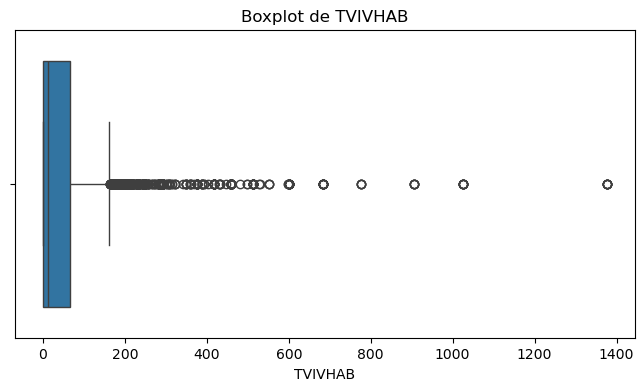

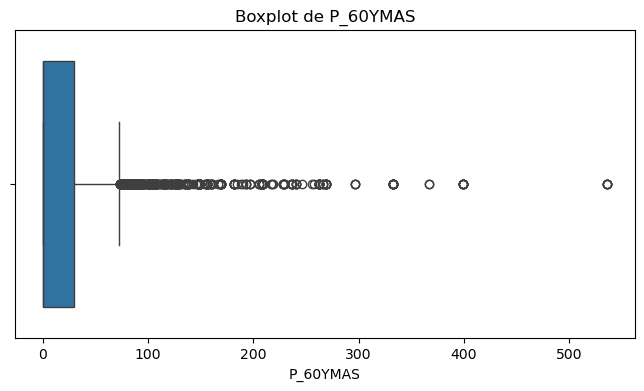

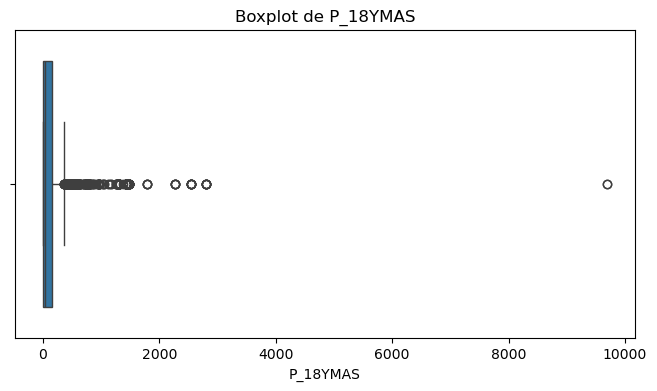

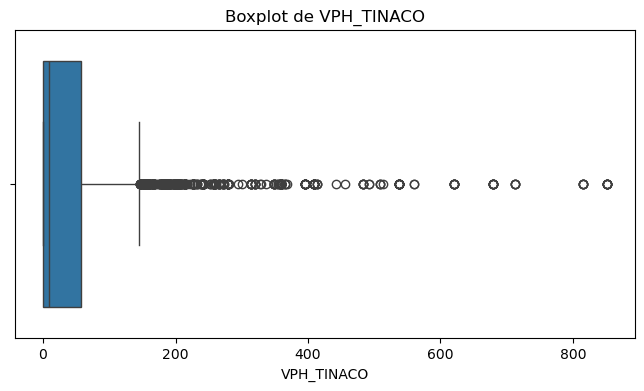

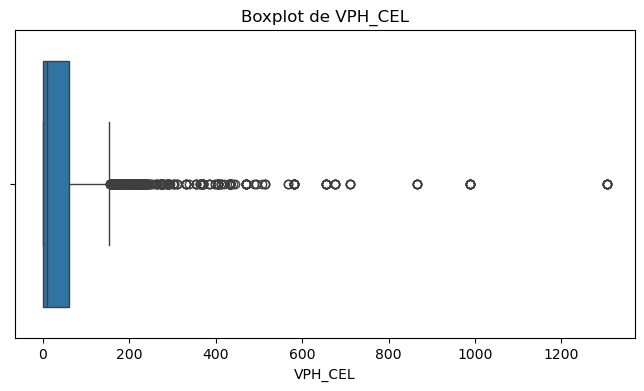

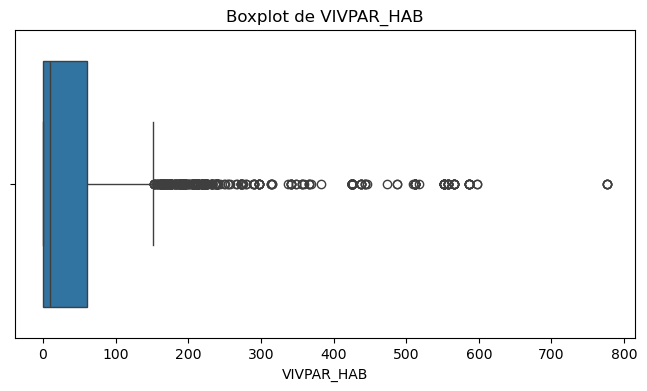

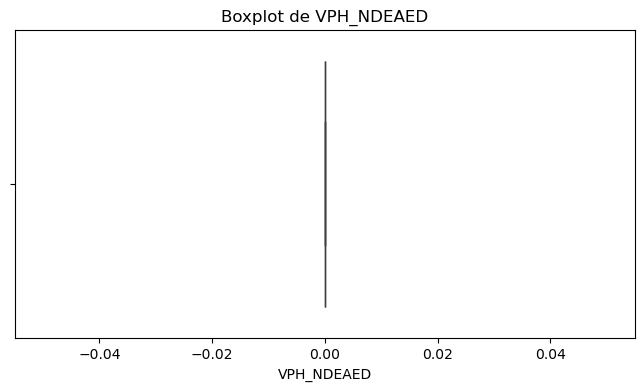

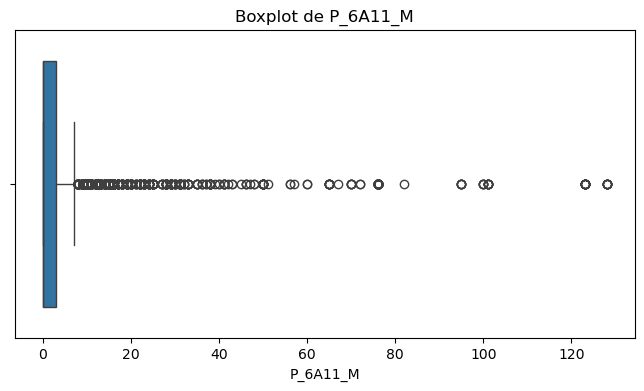

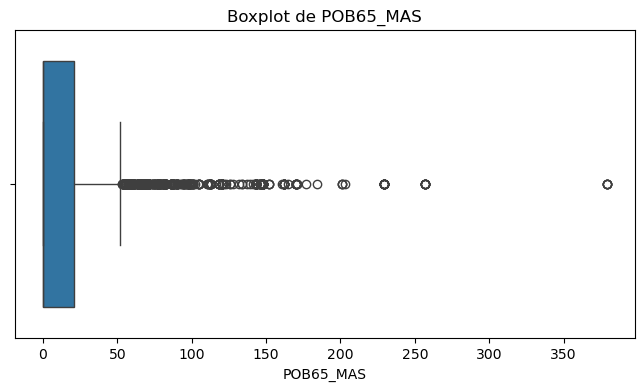

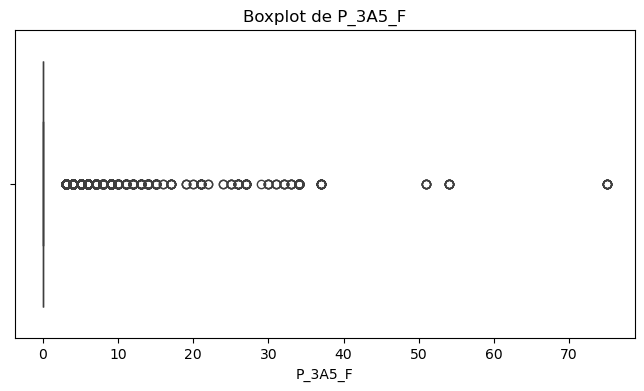

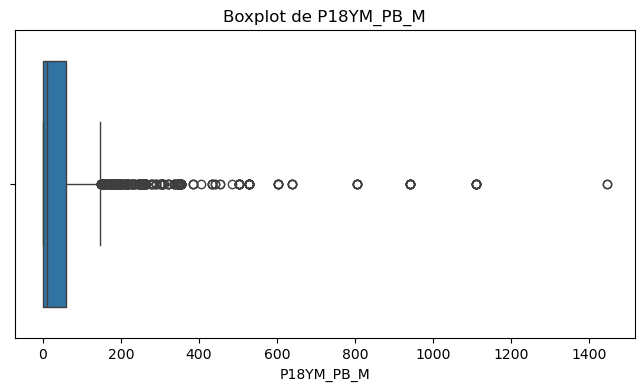

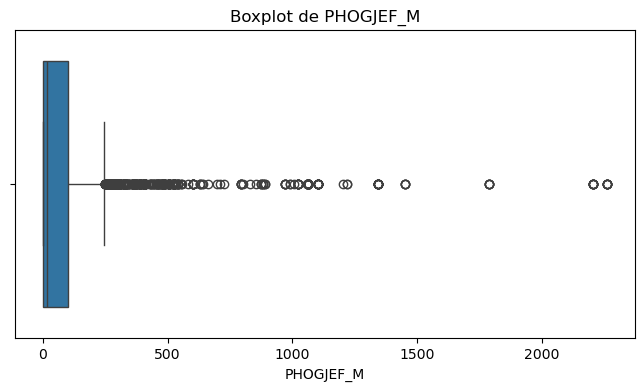

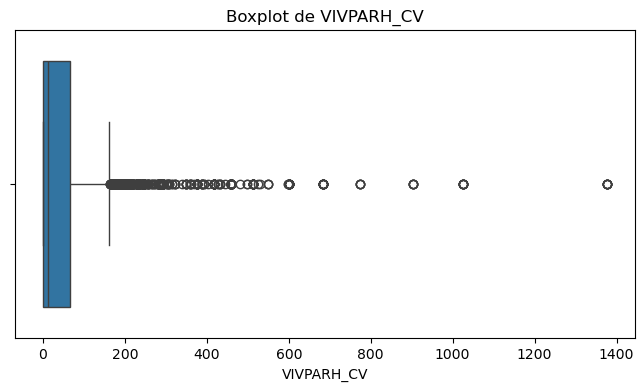

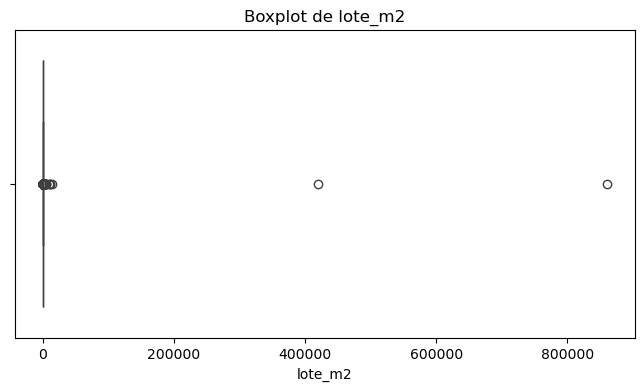

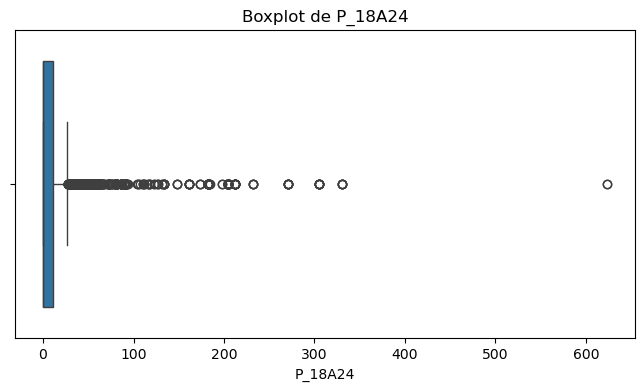

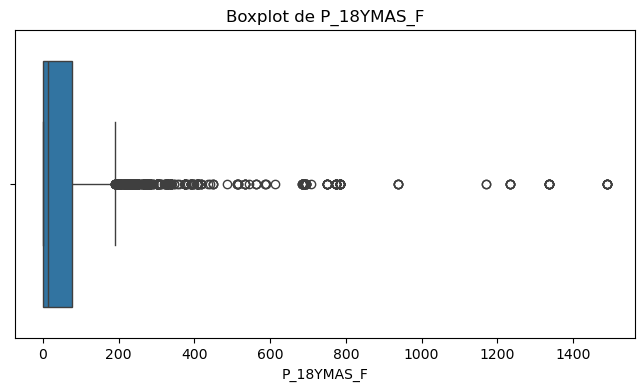

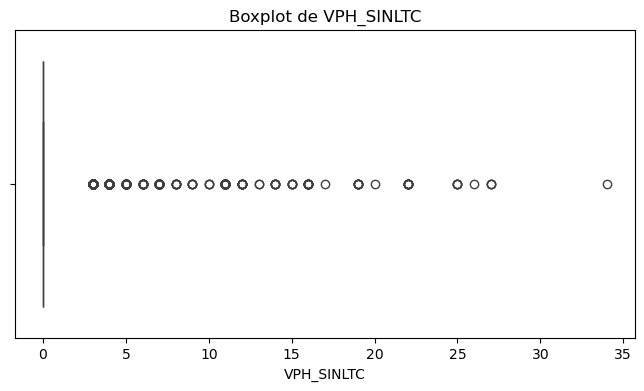

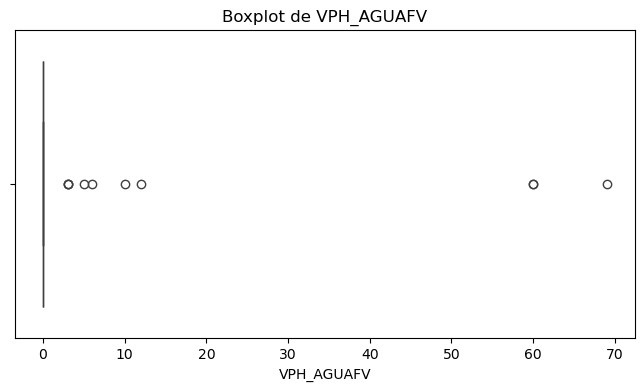

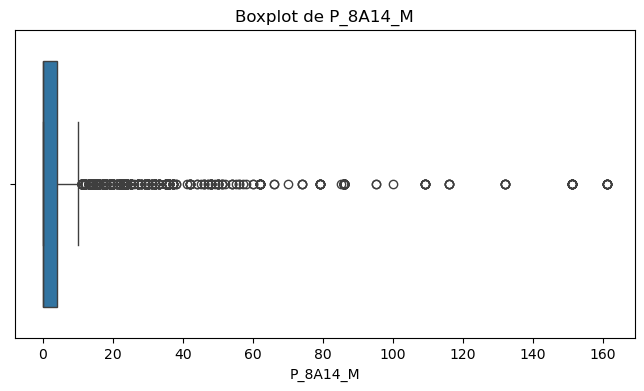

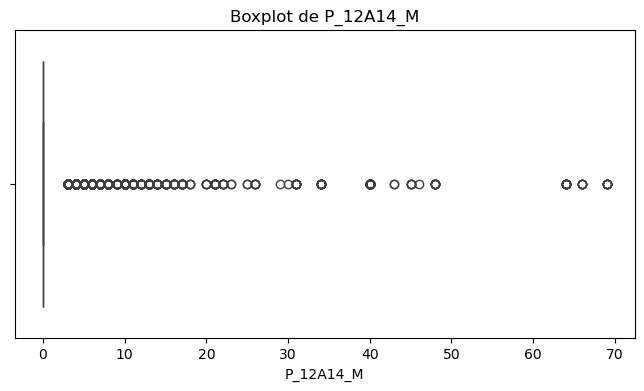

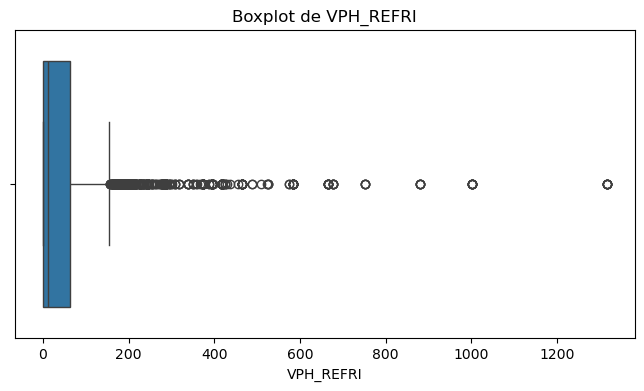

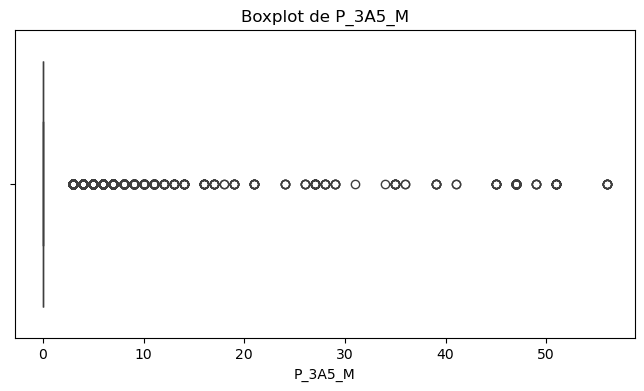

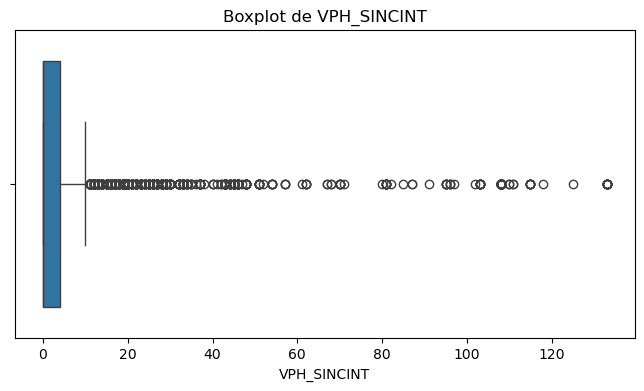

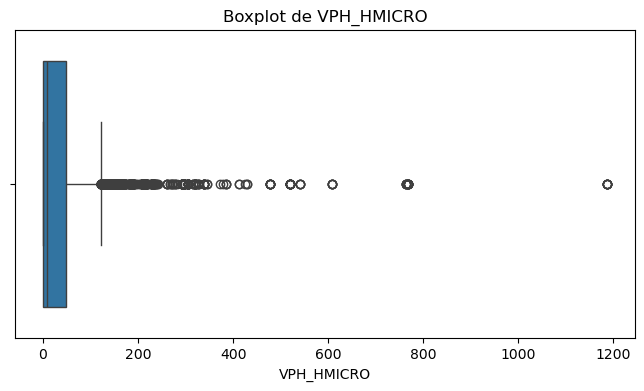

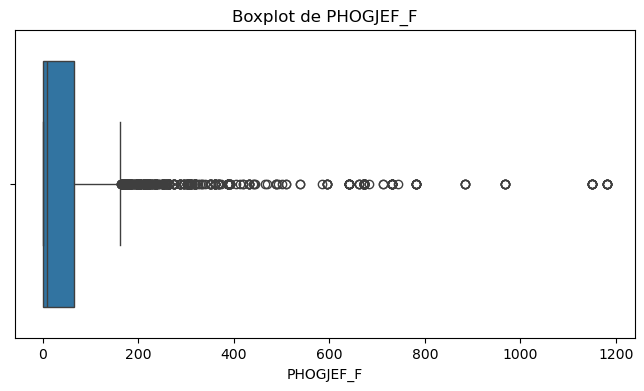

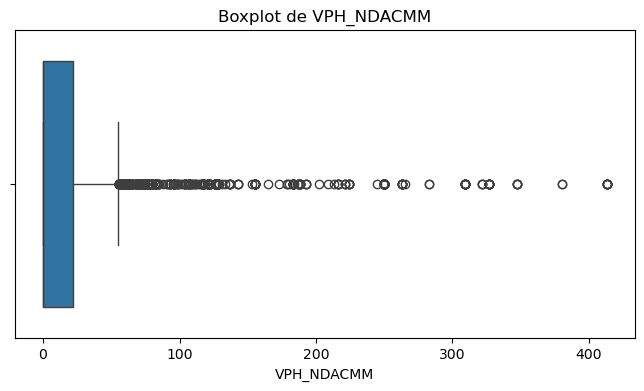

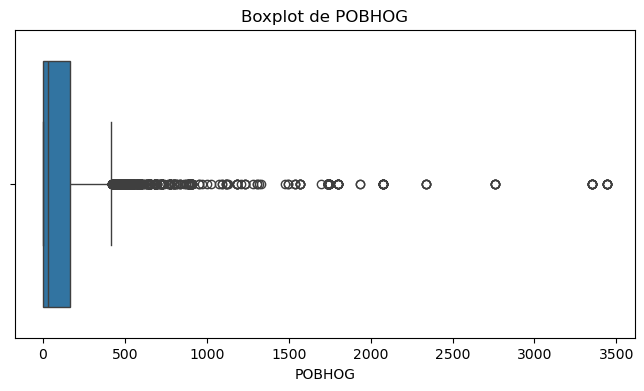

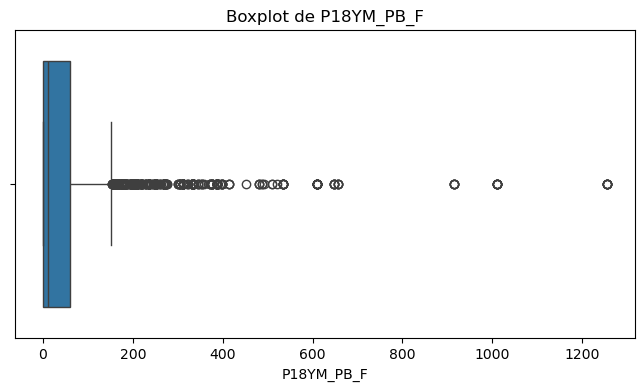

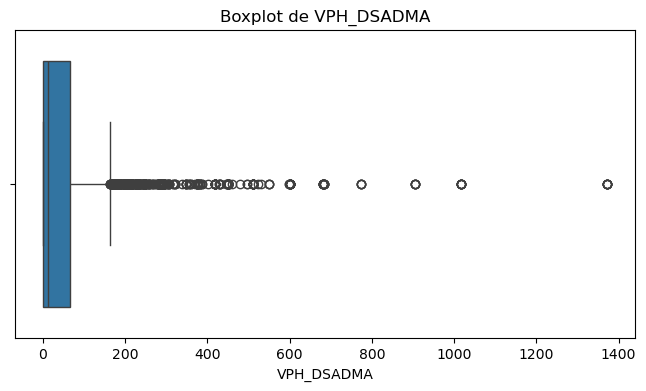

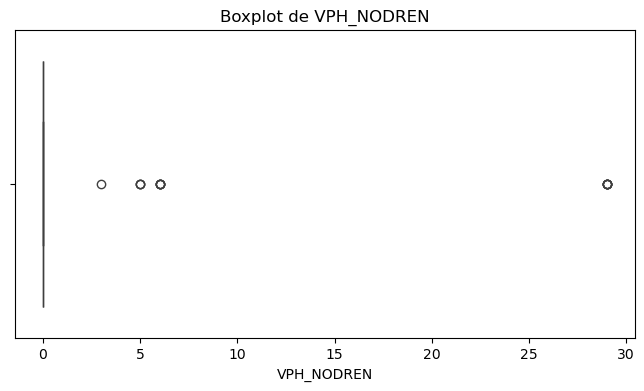

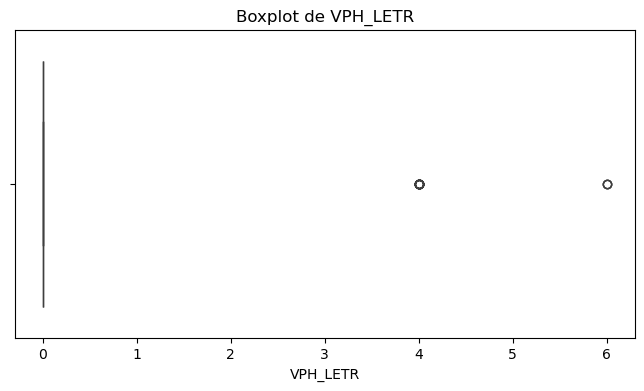

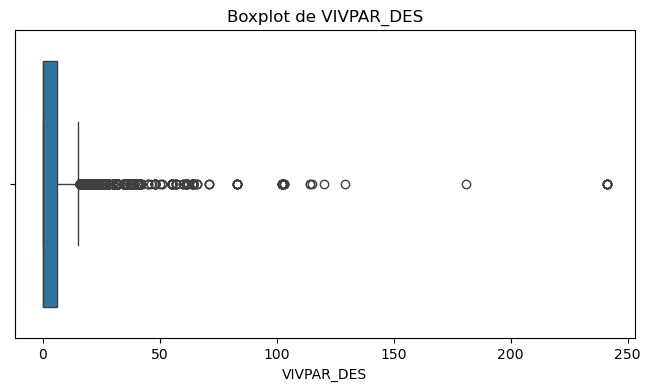

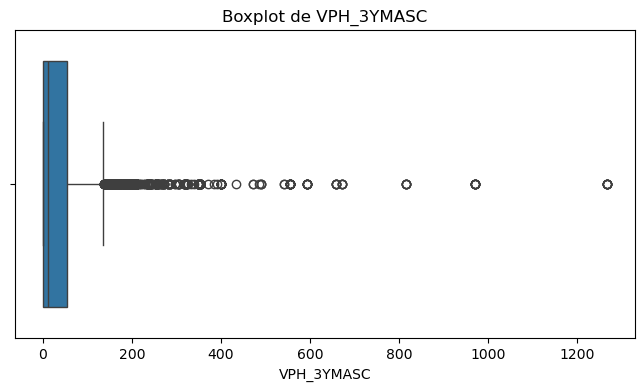

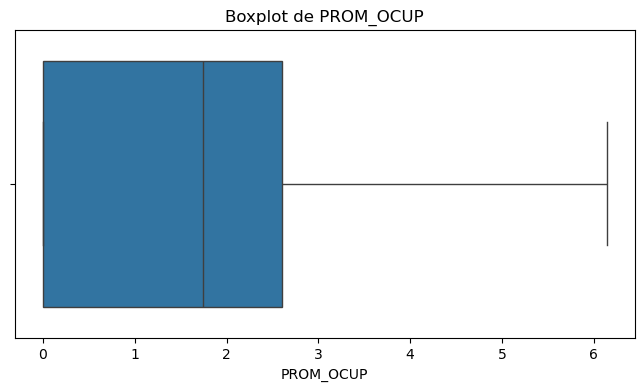

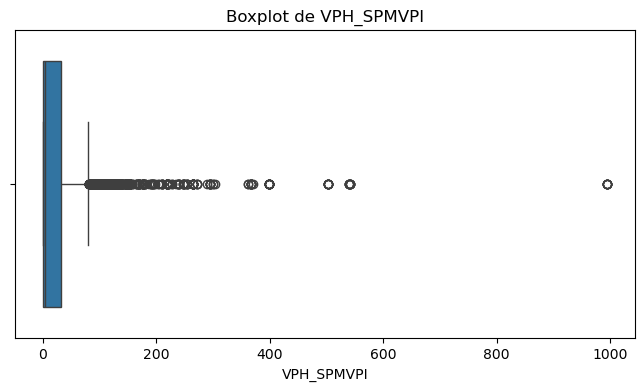

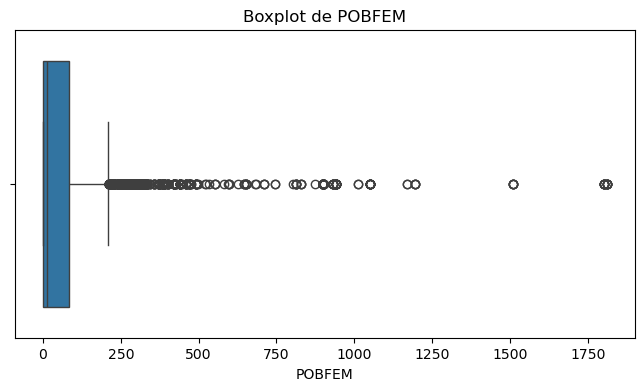

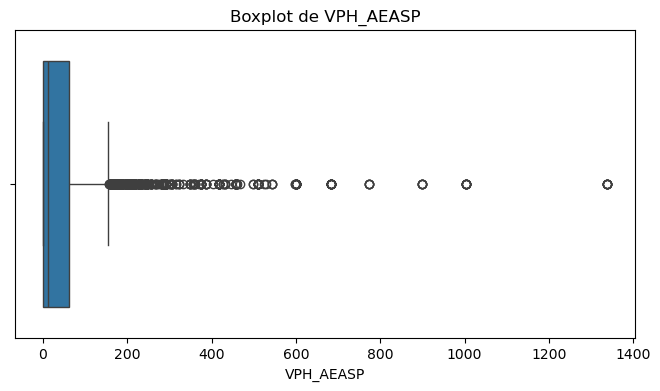

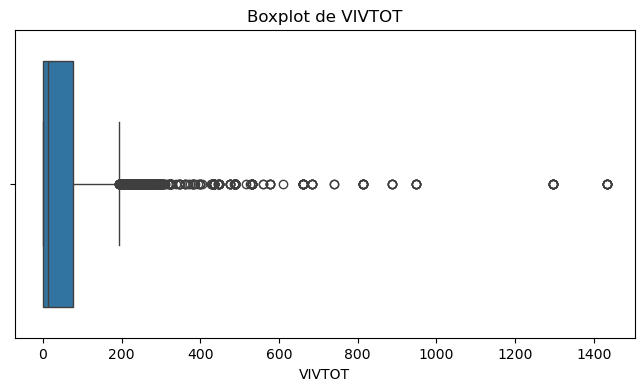

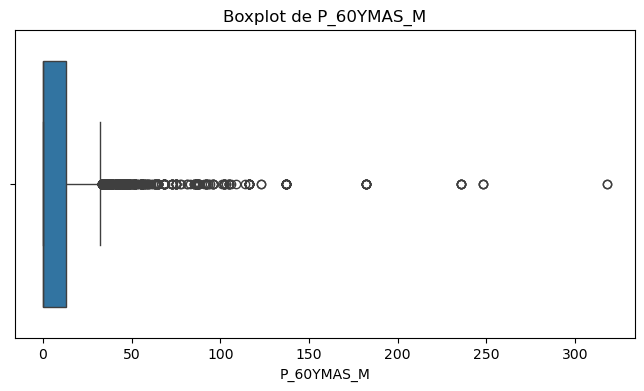

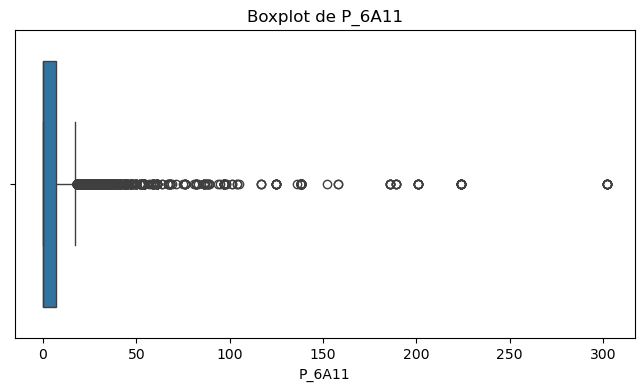

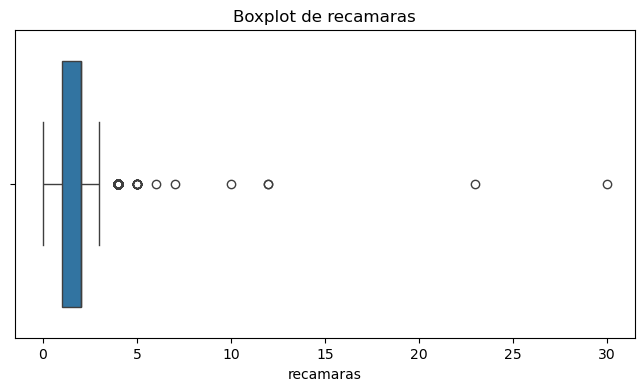

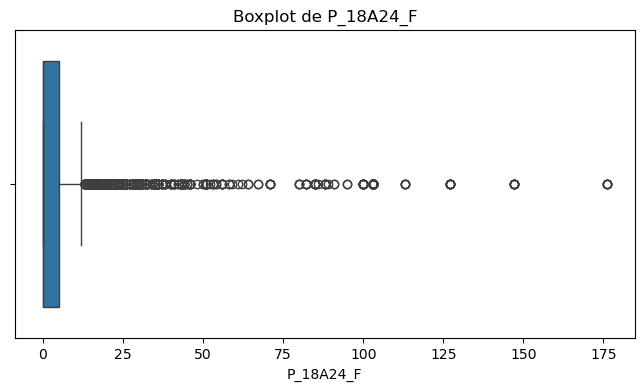

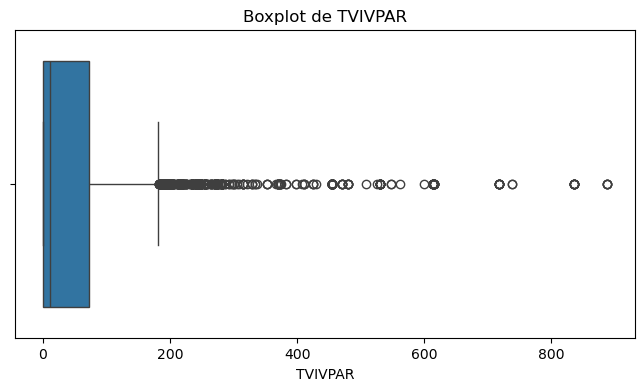

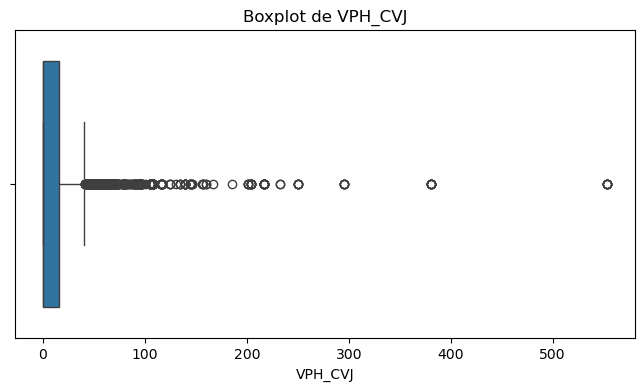

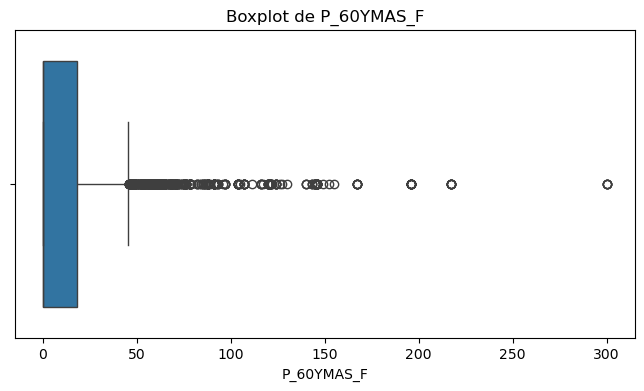

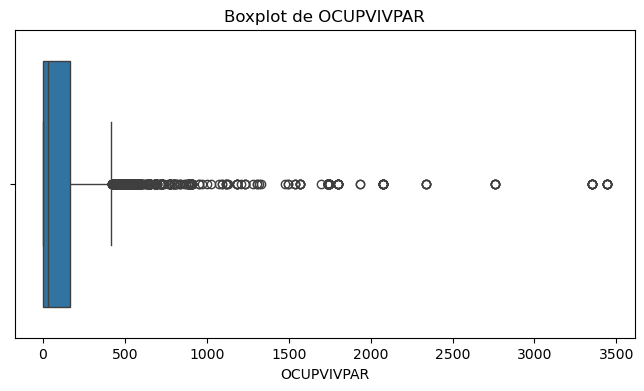

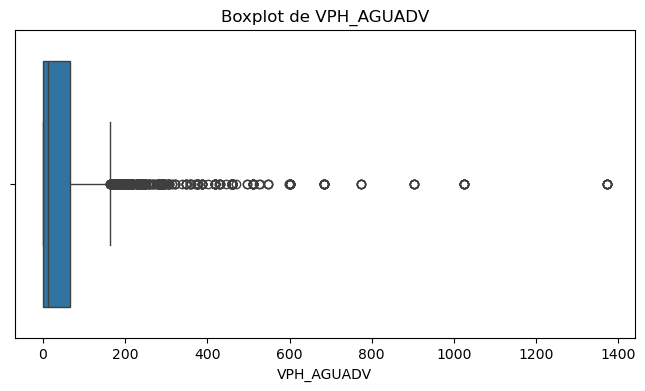

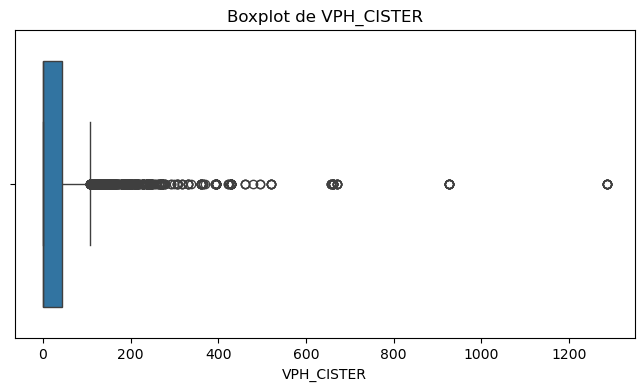

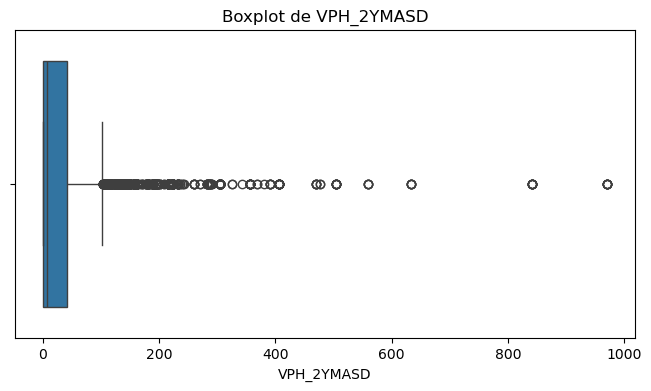

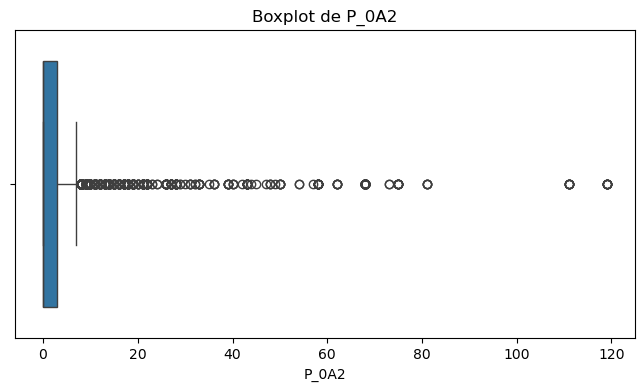

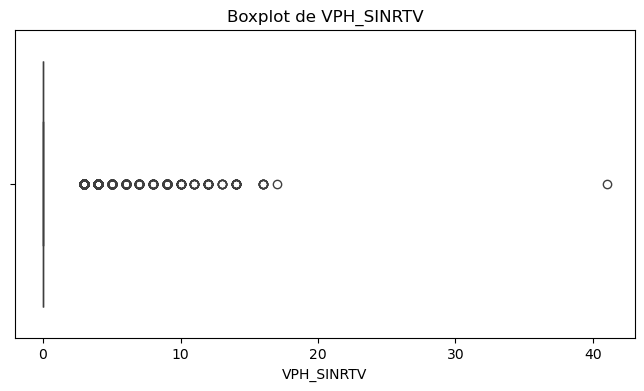

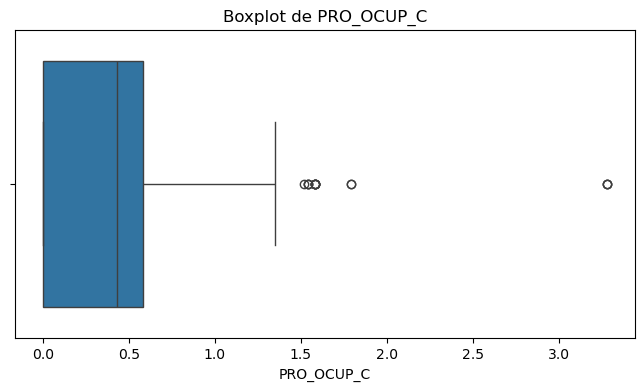

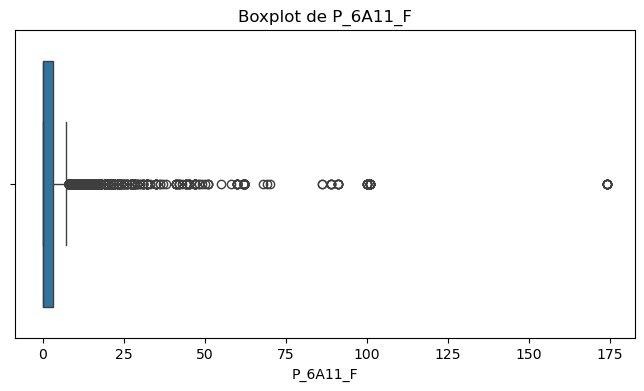

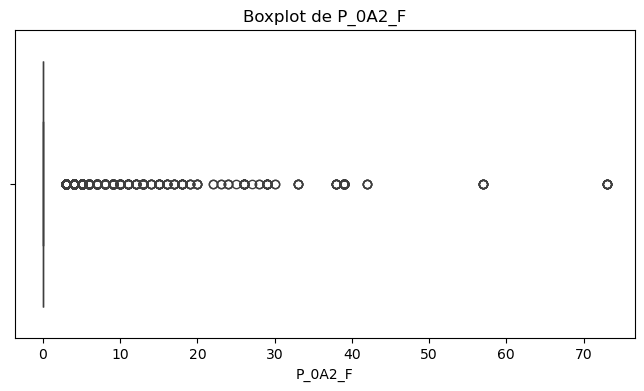

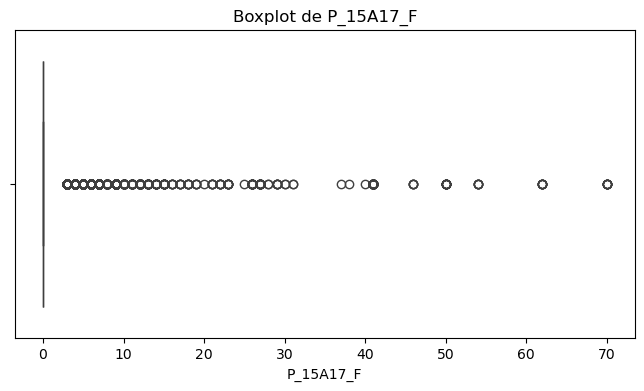

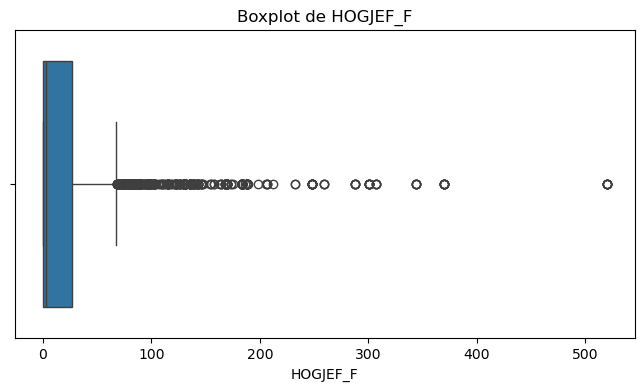

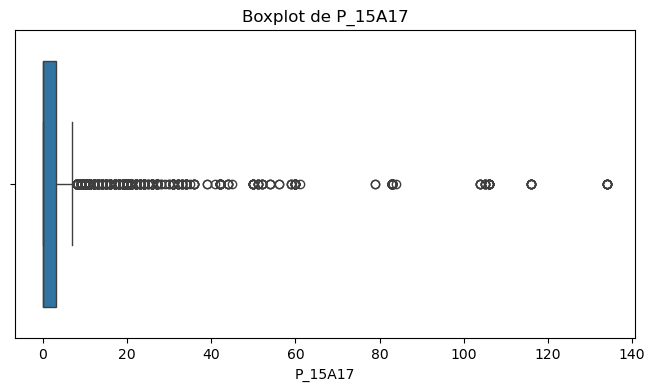

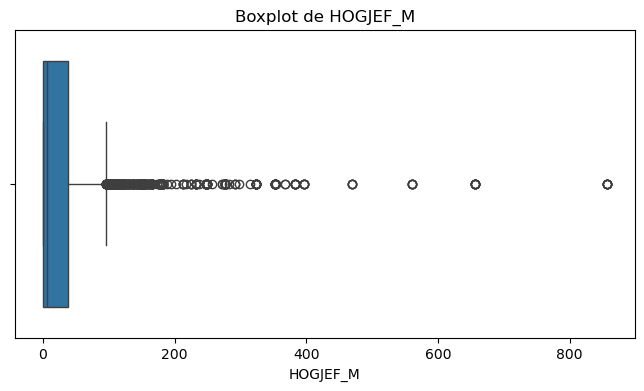

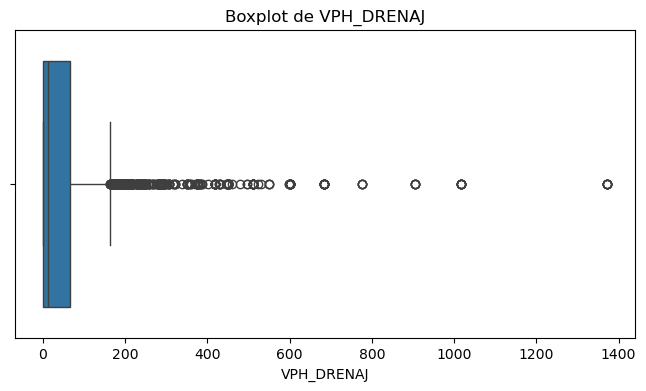

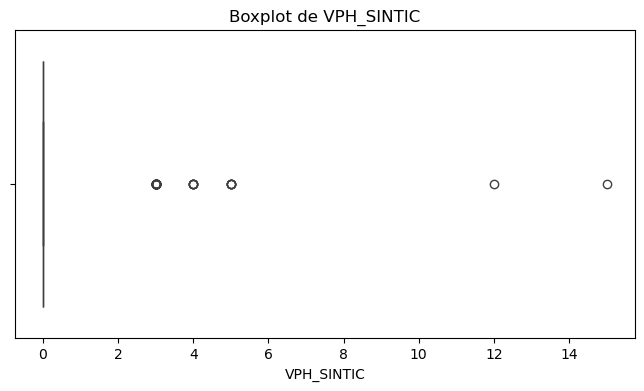

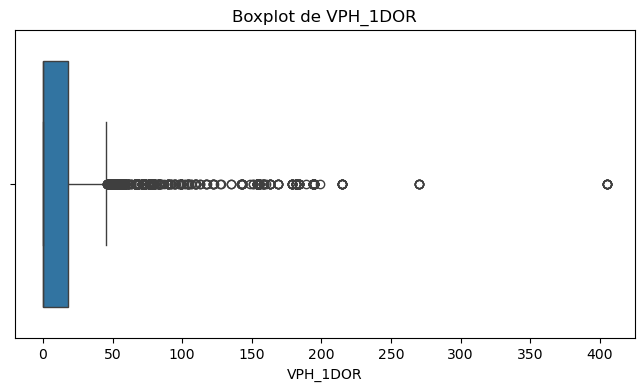

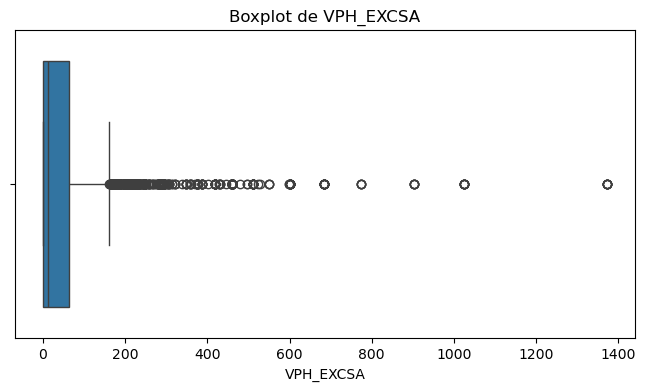

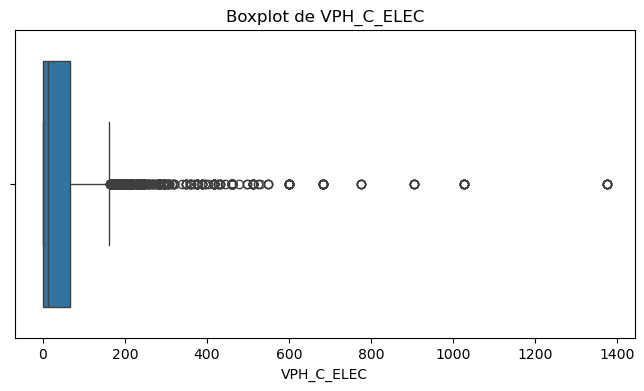

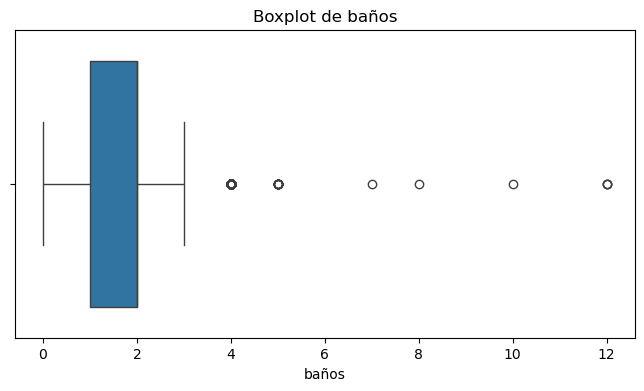

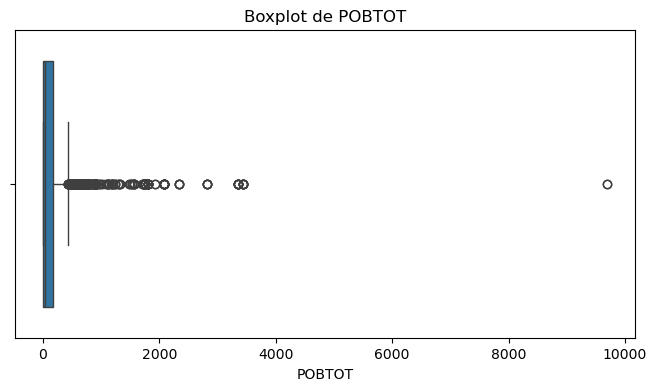

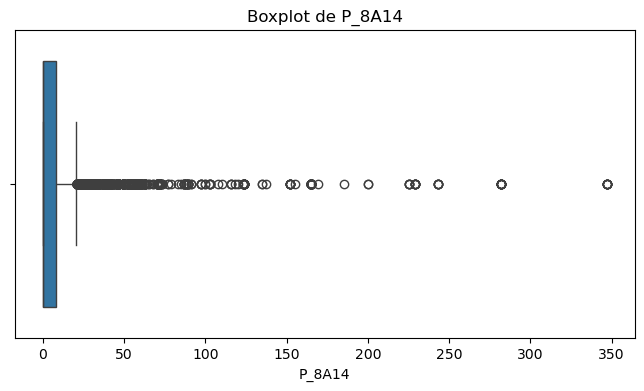

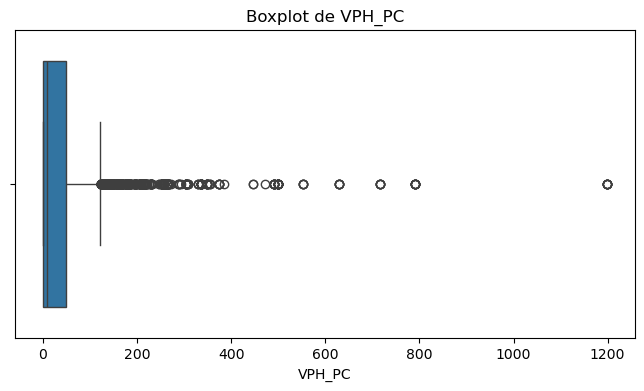

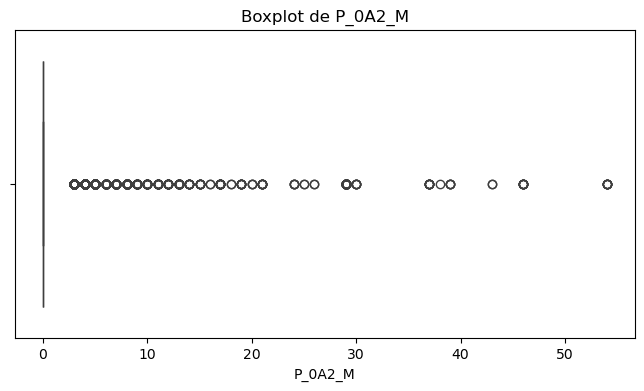

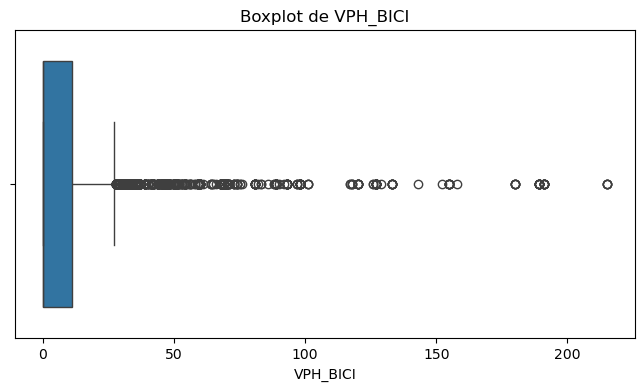

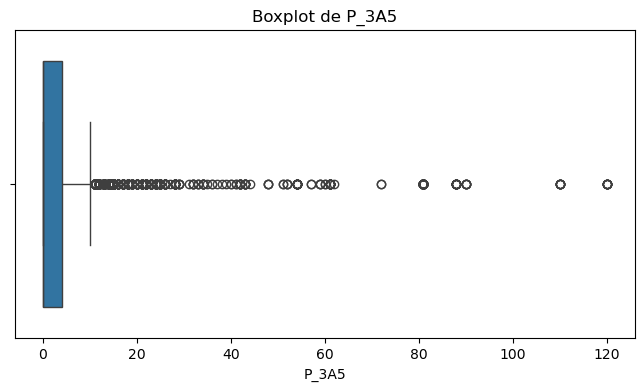

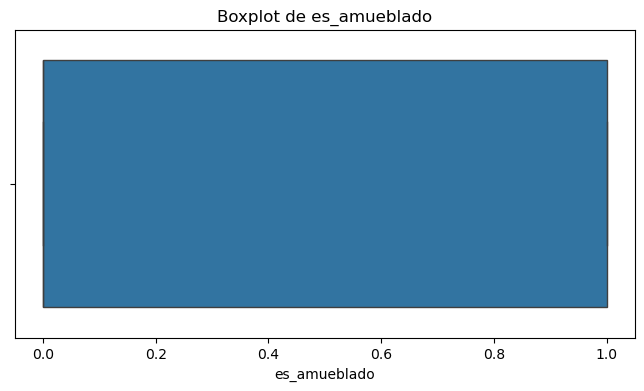

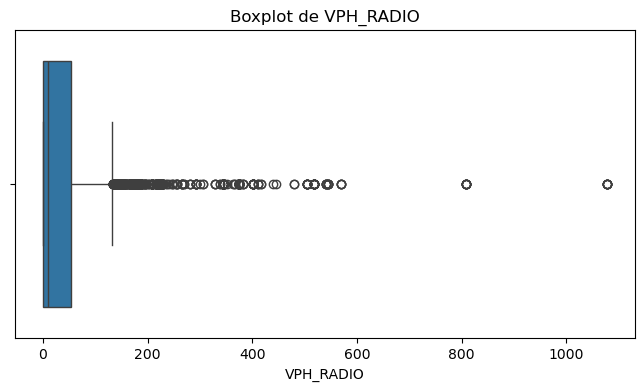

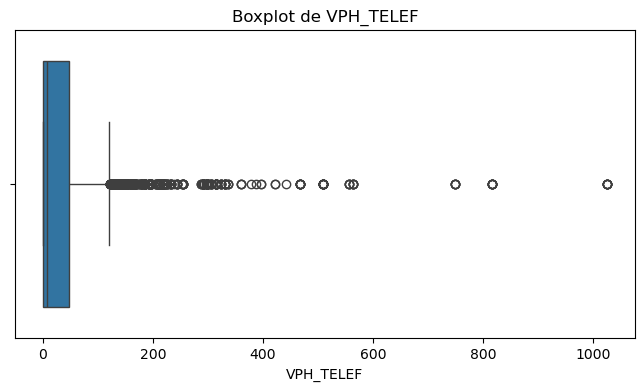

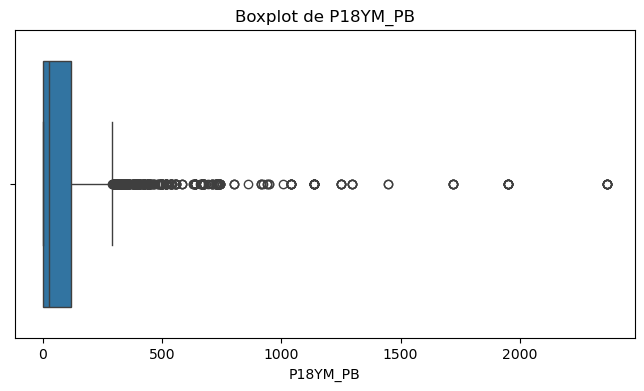

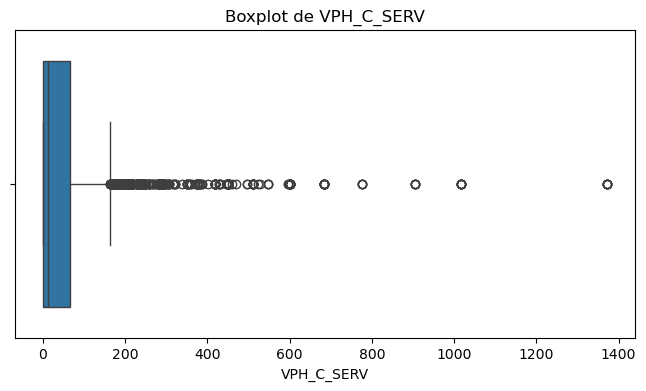

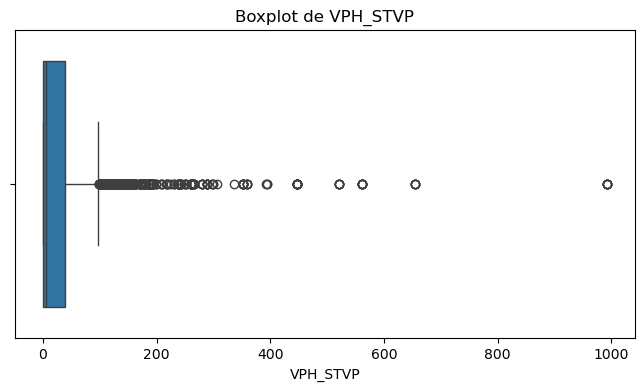

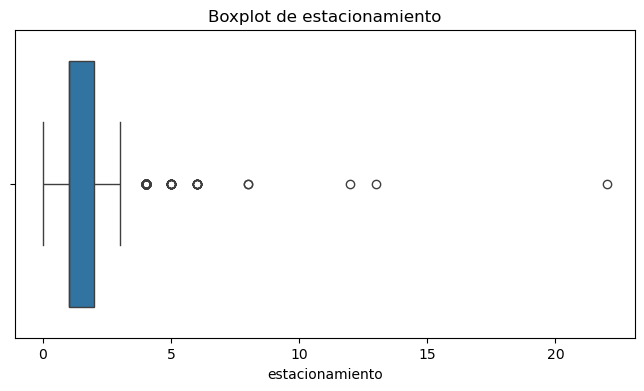

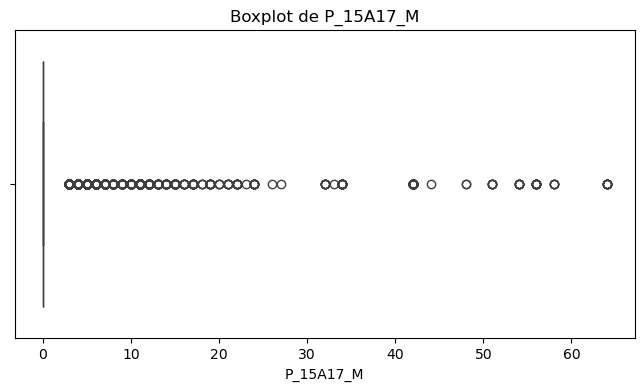

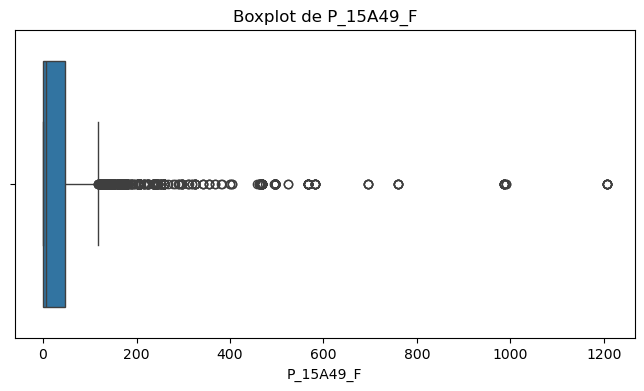

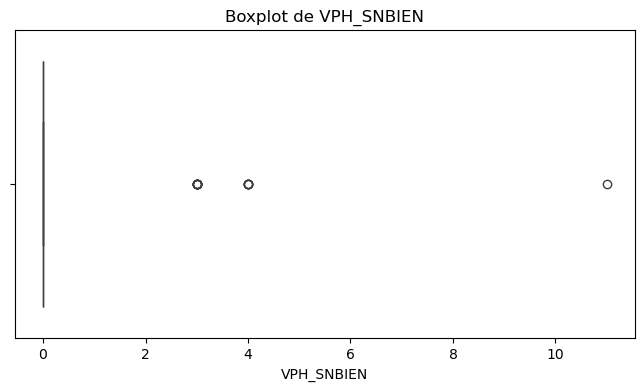

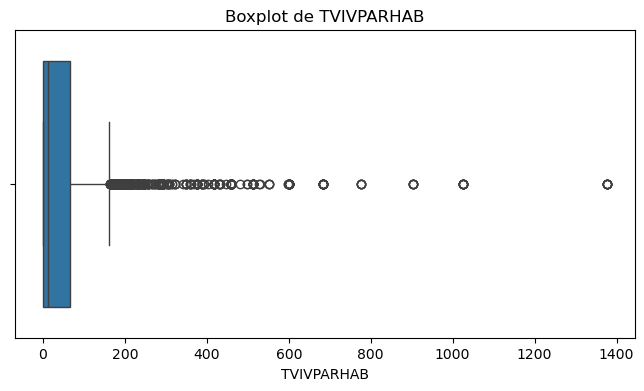

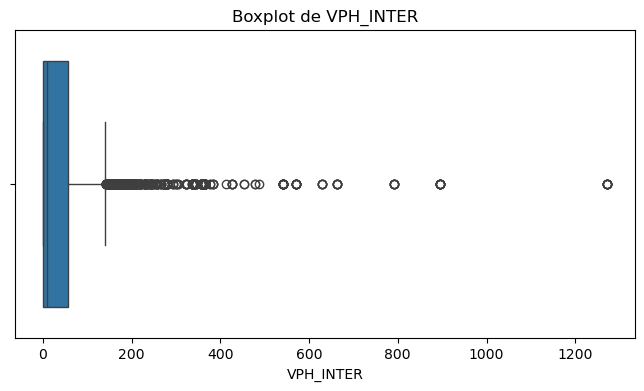

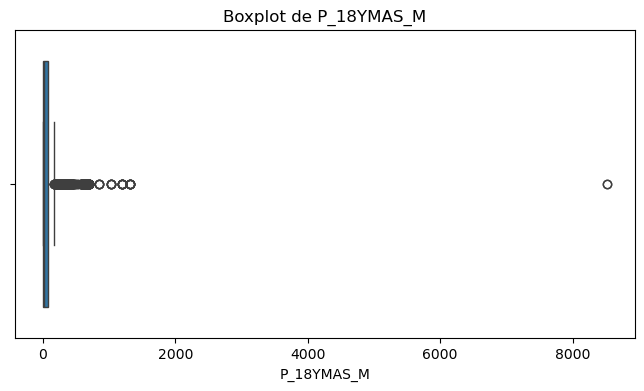

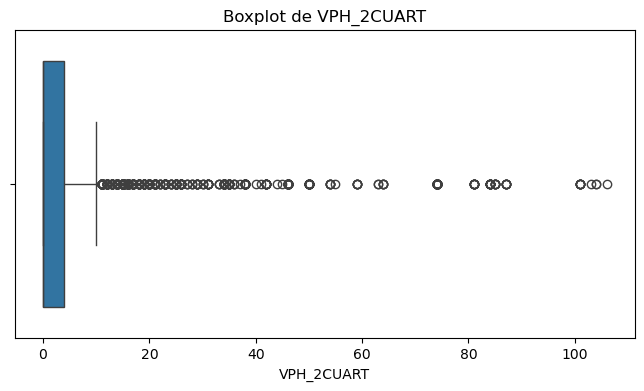

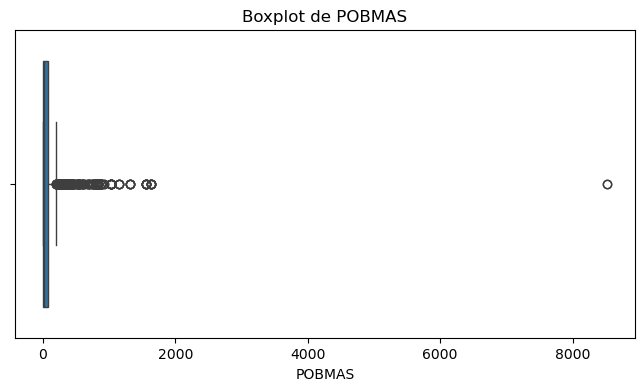

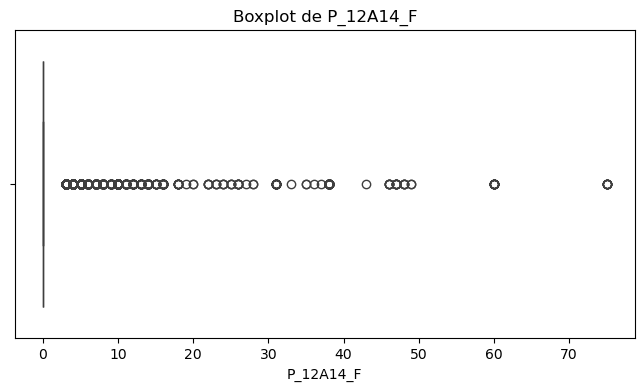

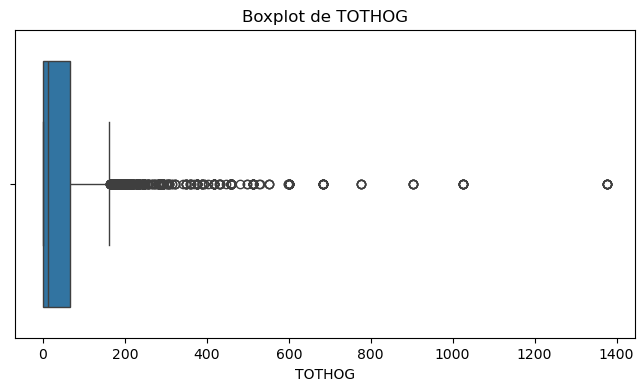

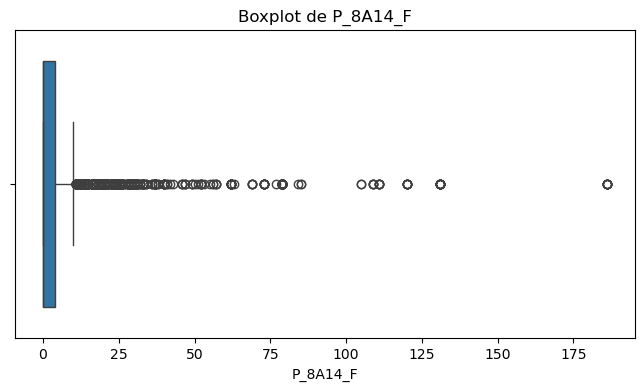

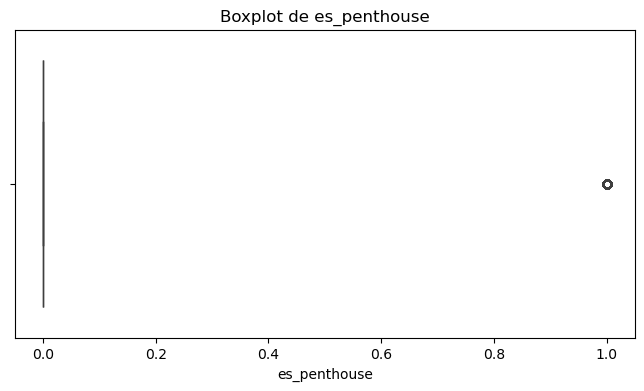

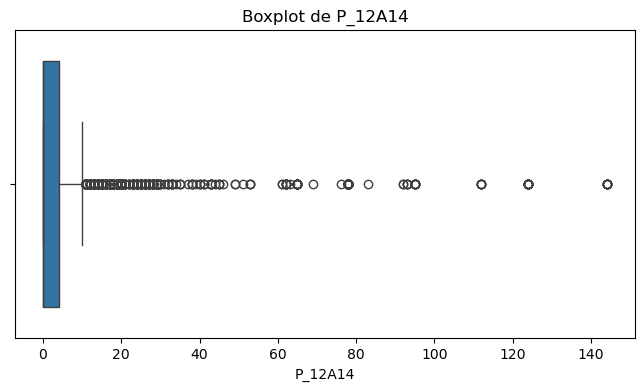

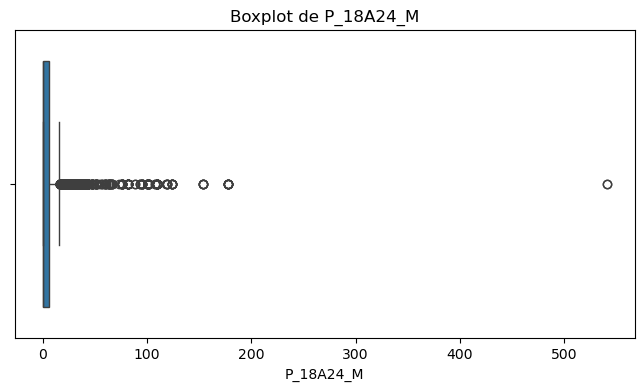

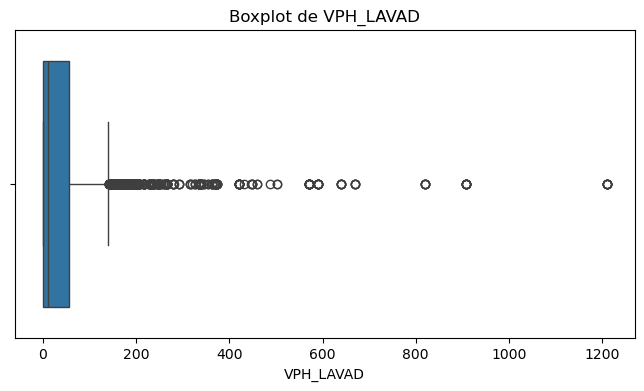

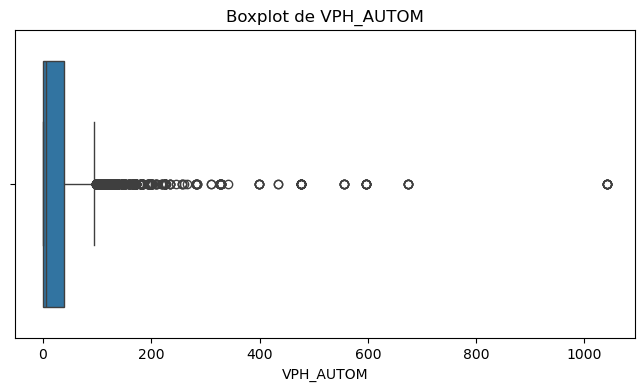

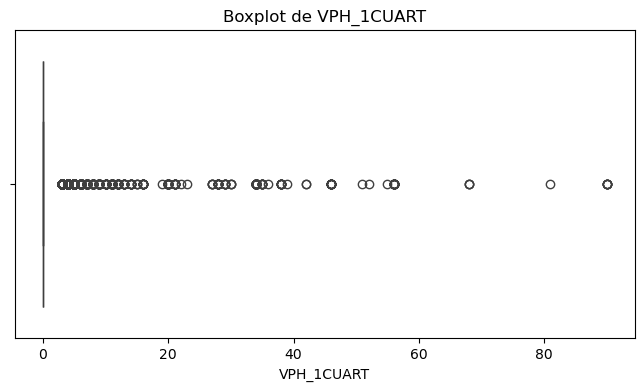

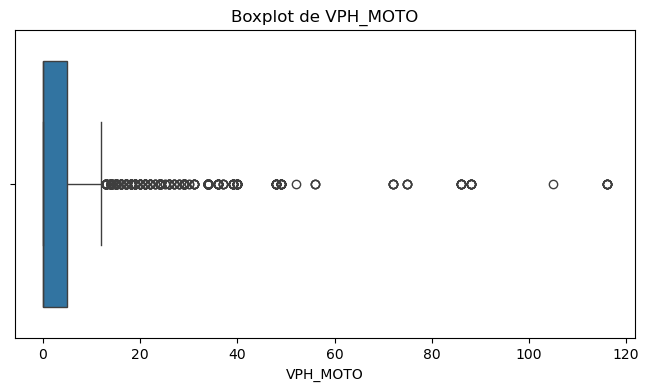

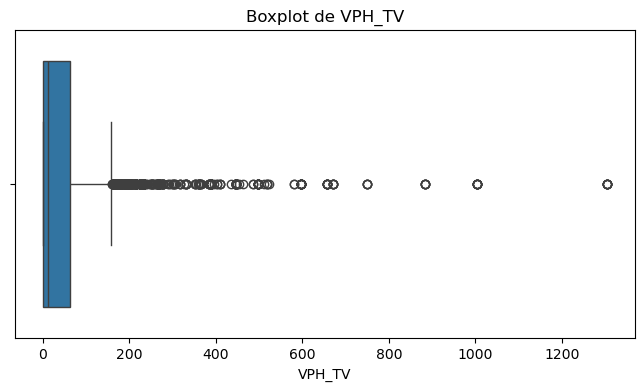

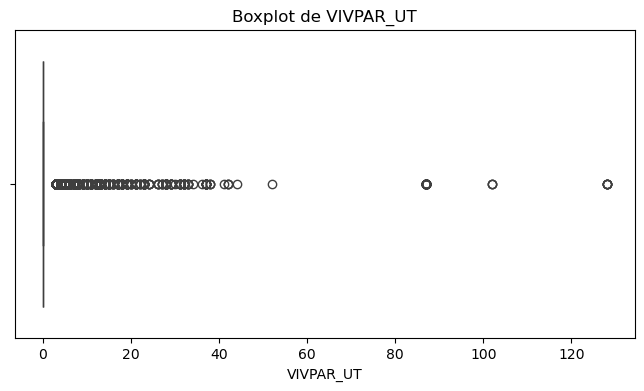

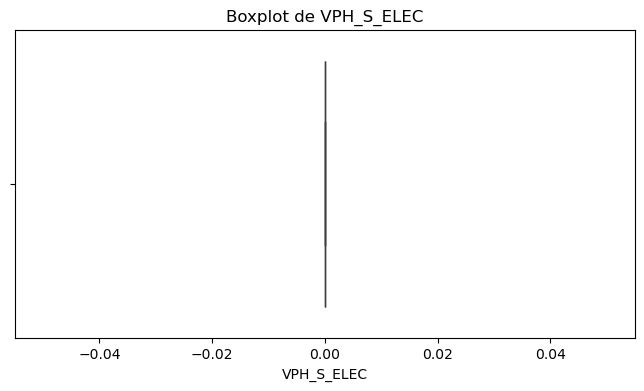

In [51]:
# Aplicar la función a las columnas numéricas
for col in numeric_cols:
    outliers = detectar_outliers_iqr(df, col)
    print(f"\nNúmero de outliers en {col}: {len(outliers)}")
    if len(outliers) > 0:
        print(outliers[[col]].head())
    # Visualizar outliers
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot de {col}")  

identificamos 2 outliers evidentes y muy seprados del resto de los datos en lote_m2, los cuales eliminamos

In [52]:
df.sort_values('lote_m2', ascending=False).head(10)

precio_mxn  lote_m2  recamaras  baños  estacionamiento  es_amueblado  \
3212      26000.0   860000        2.0    2.0              2.0             1   
20259     19000.0   420000        1.0    1.0              1.0             0   
1510      20000.0    13000        2.0    2.0              1.0             0   
3737      37000.0    10000        2.0    2.0              2.0             0   
3713      30000.0     9974        1.0    1.0              0.0             0   
20829     32500.0     9140        2.0    2.0              1.0             0   
915       49000.0     5000        3.0    3.0              2.0             0   
12        37000.0     5000        3.0    2.0              2.0             0   
14018     10400.0     4000        2.0    2.0              1.0             0   
9810      33000.0     3000        1.0    1.0              2.0             1   

       es_penthouse                                          direccion  \
3212              0               revillagigedo 18 centro   cuauhtemoc   
20259             0  alvaro obregon  guadalupe inn guadalupe inn  a...   
1510              0      av. victor hugo portales norte  benito juarez   
3737              0  lago andromaco ampliacion granada  miguel hidalgo   
3713              0             rio churubusco 601 xoco  benito juarez   
20829             0  avenida benjamin franklin hipodromo condesa  c...   
915               0  cumbres de santa fe santa fe cuajimalpa  cuaji...   
12                0  loma de la palma 29 lomas de vista hermosa  cu...   
14018             0  prolongacion ocote san jose de los cedros  cua...   
9810              0     av tecamachalco reforma social  miguel hidalgo   

              colonia    cp  ...                        road quarter  \
3212       cuauhtemoc  6500  ...  Avenida Insurgentes Centro    None   
20259   guadalupe inn  1020  ...          Avenida Revolución    None   
1510   portales norte  3303  ...         Avenida Víctor Hugo    None   
3737          hidalgo  1120  ...                  Calle Tula    None   
3713             xoco  3330  ...         Avenida Universidad    None   
20829       hipodromo  6100  ...   Avenida Benjamín Franklin    None   
915          santa fe  1210  ...         Avenida Carlos Lazo    None   
12         cuajimalpa  5000  ...              Avenida México    None   
14018      los cedros  1510  ...               Calle Casitas    None   
9810          hidalgo  1120  ...                Calle Bejuco    None   

                     borough  postcode  longitud_1  latitud_1   neighbourhood  \
3212              Cuauhtémoc     06500  -99.159289  19.432015      cuauhtemoc   
20259         Álvaro Obregón     01040  -99.190509  19.351696   guadalupe inn   
1510           Benito Juárez     03303  -99.148644  19.370439  portales norte   
3737          Álvaro Obregón     01120  -99.206255  19.400896         hidalgo   
3713           Benito Juárez     03330  -99.170877  19.360889            xoco   
20829             Cuauhtémoc     06100  -99.179713  19.406483       hipodromo   
915           Álvaro Obregón     01376  -99.263476  19.362460        santa fe   
12     Cuajimalpa de Morelos     05000  -99.299234  19.367031      cuajimalpa   
14018         Álvaro Obregón     01377  -99.243126  19.368324      los cedros   
9810          Álvaro Obregón     01120  -99.208977  19.400287         hidalgo   

      distancia                                        source_file  \
3212   0.013051  merged_inmuebles24_departamentos_duckdb_2025-1...   
20259  0.000689  merged_inmuebles24_departamentos_duckdb_2025-1...   
1510   0.000350  merged_inmuebles24_departamentos_duckdb_2025-1...   
3737   0.042794  merged_inmuebles24_departamentos_duckdb_2025-1...   
3713   0.002160  merged_inmuebles24_departamentos_duckdb_2025-1...   
20829  0.001404  merged_inmuebles24_departamentos_duckdb_2025-1...   
915    0.014988  merged_inmuebles24_departamentos_duckdb_2025-1...   
12     0.021311  merged_inmuebles24_departamentos_duckdb_2025-1...   
14018  

In [53]:
# Identificar los índices de los dos outliers más grandes
outliers = df.sort_values('lote_m2', ascending=False).head(2).index

In [54]:
# Eliminar los outliers del DataFrame
df = df.drop(outliers)


In [55]:
categorical_columns = list(df.select_dtypes(include=["object", "category"]).columns)
categorical_columns.remove('direccion')

In [56]:
df = pd.get_dummies(df, columns=['municipio','colonia_top10'], drop_first=True)

In [57]:
df.head()

precio_mxn  lote_m2  recamaras  baños  estacionamiento  es_amueblado  \
0     18000.0      130        2.0    1.0              1.0             0   
1     30000.0      198        2.0    2.0              2.0             0   
2     23500.0      110        2.0    2.0              1.0             1   
3     14000.0       59        2.0    1.0              1.0             0   
4     14000.0       30        1.0    1.0              1.0             1   

   es_penthouse                                          direccion  \
0             0         rio becerra 135 8 de agosto  benito juarez   
1             0     avenida rio mixcoac 206 acacias  benito juarez   
2             0  av. san francisco  col. del valle actipan  ben...   
3             0              calle 2 agricola pantitlan  iztacalco   
4             0  av. tamaulipas 257 alvaro obregon  ciudad de m...   

              colonia    cp  ... colonia_top10_cuajimalpa  \
0         8 de agosto  1180  ...                    False   
1             acacias  3240  ...                    False   
2             actipan  3230  ...                    False   
3  agricola pantitlan  8100  ...                    False   
4      alvaro obregon  9230  ...                    False   

  colonia_top10_cuauhtemoc  colonia_top10_del valle centro  \
0                    False                           False   
1                    False                           False   
2                    False                           False   
3                    False                           False   
4                    False                           False   

   colonia_top10_hidalgo colonia_top10_hipodromo colonia_top10_napoles  \
0                  False                   False                 False   
1                  False                   False                 False   
2                  False                   False                 False   
3                  False                   False                 False   
4                  False                   False                 False   

  colonia_top10_narvarte poniente colonia_top10_otros colonia_top10_santa fe  \
0                           False                True                  False   
1                           False                True                  False   
2                           False                True                  False   
3                           False                True                  False   
4                           False                True                  False   

  colonia_top10_xoco  
0              False  
1              False  
2              False  
3              False  
4              False  

[5 rows x 178 columns]

In [58]:
df.shape

(8289, 178)

# Clustering
Realiza un análisis de clustering para agrupar los datos en diferentes segmentos.

In [59]:
df_analysis = df[numeric_cols].copy()

In [60]:
#df_analysis['random'] = np.random.rand(len(df_analysis))

In [61]:
cols = df_analysis.columns

In [62]:
# Escalar los datos
scaler = StandardScaler()
df_analysis[cols] = scaler.fit_transform(df_analysis[cols])

In [63]:
## Arreglar los nulos y quitar esta celda
df_analysis = df_analysis.dropna()

In [64]:
df_analysis.dtypes[120:]

Series([], dtype: object)

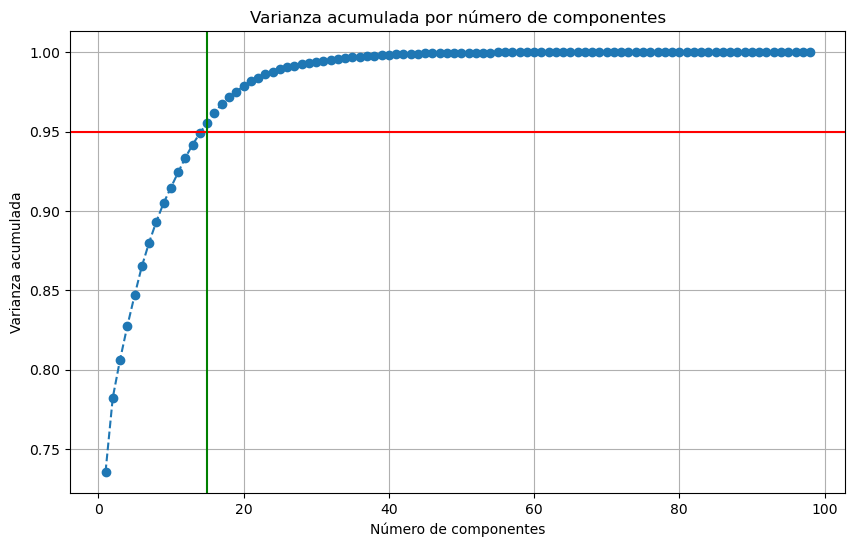

Número óptimo de componentes: 15


In [65]:
# Crear el modelo PCA sin especificar n_components
pca = PCA()
pca.fit(df_analysis)

# Calcular la varianza acumulada
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

#Gráfica de la varianza acumulada
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Varianza acumulada por número de componentes')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.axvline(x=np.argmax(cumulative_variance >= 0.95) + 1, color='g', linestyle='-')
plt.grid()
plt.show()

# Elegir el número de componentes que expliquen al menos el 95% de la varianza
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Número óptimo de componentes: {n_components}")



In [66]:
print("Varianza acumulada:")
print(cumulative_variance)


Varianza acumulada:
[0.73537786 0.7823285  0.80620107 0.82740418 0.84673912 0.86502554
 0.88006542 0.89333924 0.90497736 0.91469708 0.92429786 0.93360797
 0.9418233  0.94905673 0.95563488 0.96172283 0.96730788 0.97149325
 0.97517848 0.97860472 0.9816406  0.98400494 0.98607111 0.98770909
 0.98920345 0.99041291 0.99156512 0.99246632 0.99325383 0.99398823
 0.99466604 0.99530816 0.99590011 0.99637798 0.99683512 0.99724383
 0.99760738 0.997923   0.99820347 0.99845201 0.99865803 0.99884934
 0.99902813 0.99919361 0.99932539 0.99941966 0.99949397 0.99956031
 0.99961812 0.99966631 0.99971117 0.9997518  0.99978703 0.99981659
 0.99984498 0.9998707  0.99989395 0.99991255 0.99992933 0.999942
 0.99995199 0.99996015 0.99996734 0.99997383 0.99997986 0.9999829
 0.99998568 0.99998819 0.99999005 0.99999177 0.99999322 0.99999452
 0.9999958  0.9999969  0.9999978  0.99999823 0.99999863 0.99999896
 0.9999992  0.99999937 0.99999952 0.99999964 0.99999975 0.99999985
 0.99999991 0.99999994 0.99999996 0.99999997 

In [67]:
# Aplicar PCA con el número óptimo de componentes
pca = PCA(n_components=n_components)
pca_data = pca.fit_transform(df_analysis)

In [68]:
# Importancia de cada componente (varianza explicada)
explained_variance = pca.explained_variance_ratio_
print("Varianza explicada por cada componente:")
for i, var in enumerate(explained_variance):
    print(f"Componente {i+1}: {var:.2%}")

Varianza explicada por cada componente:
Componente 1: 73.54%
Componente 2: 4.70%
Componente 3: 2.39%
Componente 4: 2.12%
Componente 5: 1.93%
Componente 6: 1.83%
Componente 7: 1.50%
Componente 8: 1.33%
Componente 9: 1.16%
Componente 10: 0.97%
Componente 11: 0.96%
Componente 12: 0.93%
Componente 13: 0.82%
Componente 14: 0.72%
Componente 15: 0.66%


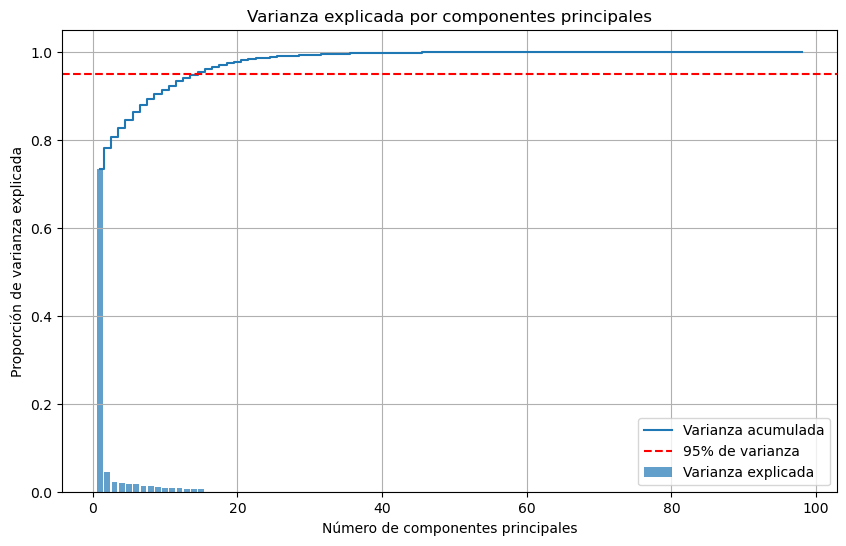

In [69]:
# Gráfica de varianza explicada por cada componente
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, label='Varianza explicada')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Varianza acumulada')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% de varianza')
plt.xlabel('Número de componentes principales')
plt.ylabel('Proporción de varianza explicada')
plt.title('Varianza explicada por componentes principales')
plt.legend(loc='best')
plt.grid()
plt.show()

In [70]:
# Contribución de las características originales a los primeros 22 componentes
components = pd.DataFrame(pca.components_[:20], columns=df_analysis.columns)
print("\nContribución de las características originales a los primeros 22 componentes:")
components.T.sort_values(by = 0, ascending=False)


Contribución de las características originales a los primeros 22 componentes:


0         1         2         3         4         5   \
POBHOG           0.118292 -0.034974  0.004090 -0.021571 -0.030249 -0.007720   
OCUPVIVPAR       0.118292 -0.034974  0.004090 -0.021571 -0.030249 -0.007720   
POBFEM           0.118163 -0.037833  0.007256  0.050992 -0.001800  0.003097   
P_18YMAS_F       0.118115 -0.012525  0.008453  0.071316  0.016003  0.005121   
VPH_TV           0.117720  0.061121  0.010271 -0.027020 -0.020675 -0.001105   
...                   ...       ...       ...       ...       ...       ...   
estacionamiento -0.000895 -0.057123  0.479344 -0.062962  0.099263 -0.048466   
lote_m2         -0.001700 -0.026956  0.230400 -0.046890  0.073811 -0.031157   
es_penthouse    -0.003753 -0.003998  0.222626 -0.038549  0.068527 -0.013538   
baños           -0.005452 -0.036535  0.552107 -0.071827  0.122098 -0.048400   
es_amueblado    -0.009601  0.013828 -0.100531 -0.018649 -0.130839  0.129527   

                       6         7         8         9         10        11  \
POBHOG          -0.038722  0.004037  0.001339  0.007450  0.003042  0.007952   
OCUPVIVPAR      -0.038722  0.004037  0.001339  0.007450  0.003042  0.007952   
POBFEM          -0.013623  0.003664 -0.002700  0.005908  0.001994  0.007061   
P_18YMAS_F      -0.006673  0.003481 -0.009443  0.006727  0.004000  0.009241   
VPH_TV          -0.004681  0.007352 -0.023694  0.008993  0.003397  0.009727   
...                   ...       ...       ...       ...       ...       ...   
estacionamiento  0.022633 -0.001045  0.067957 -0.047334 -0.072729  0.167874   
lote_m2          0.038735  0.043856  0.081508  0.133178  0.863153 -0.386938   
es_penthouse     0.037527 -0.002115  0.111985  0.804849 -0.366229 -0.368217   
baños            0.026460 -0.005883  0.072385 -0.120611 -0.059681  0.146026   
es_amueblado     0.209602 -0.022034  0.347645  0.406492  0.273533  0.705132   

                       12        13        14  
POBHOG          -0.009090 -0.000075 -0.006931  
OCUPVIVPAR      -0.009090 -0.000075 -0.006931  
POBFEM          -0.008235 -0.004703  0.008268  
P_18YMAS_F      -0.003212 -0.003234 -0.009343  
VPH_TV          -0.013638  0.003487 -0.012683  
...                   ...       ...       ...  
estacionamiento -0.102373  0.083464 -0.330273  
lote_m2         -0.085900 -0.009810  0.060859  
es_penthouse     0.071458 -0.026299  0.034971  
baños            0.047719  0.006973  0.014809  
es_amueblado     0.224505 -0.009908  0.035806  

[98 rows x 15 columns]

In [71]:
most_important_features = components.iloc[0].abs().sort_values(ascending=False).head(35)
print("Características más importantes del primer componente:")
print(most_important_features)

Características más importantes del primer componente:
POBHOG        0.118292
OCUPVIVPAR    0.118292
POBFEM        0.118163
P_18YMAS_F    0.118115
VPH_TV        0.117720
TVIVHAB       0.117597
VIVPARH_CV    0.117593
VPH_C_ELEC    0.117593
TOTHOG        0.117592
TVIVPARHAB    0.117592
VPH_AEASP     0.117587
VPH_AGUADV    0.117567
VPH_EXCSA     0.117555
VPH_DRENAJ    0.117516
VPH_DSADMA    0.117497
VPH_C_SERV    0.117492
PHOGJEF_M     0.117490
HOGJEF_M      0.117411
P_15A49_F     0.117370
VPH_CEL       0.117265
PHOGJEF_F     0.117224
VPH_REFRI     0.117080
VPH_RADIO     0.116977
VPH_LAVAD     0.116868
VPH_2YMASD    0.116605
VIVTOT        0.116226
P18YM_PB_F    0.115936
P18YM_PB      0.115934
VPH_3YMASC    0.115919
HOGJEF_F      0.115824
VPH_TELEF     0.115534
VPH_INTER     0.115170
VPH_TINACO    0.114710
VPH_HMICRO    0.114413
P18YM_PB_M    0.113549
Name: 0, dtype: float64


In [72]:
# Reconstrucción aproximada de los datos originales
reconstructed_data = pca.inverse_transform(pca_data)

In [73]:

# Comparar los datos originales con los reconstruidos
print("Datos originales (primeras filas):")
df_analysis.head()

Datos originales (primeras filas):


TVIVHAB  P_60YMAS  P_18YMAS  VPH_TINACO   VPH_CEL  VIVPAR_HAB  VPH_NDEAED  \
0 -0.488773 -0.516627 -0.409609   -0.522550 -0.488120   -0.538499         0.0   
1  1.818144  1.820835  1.306533    1.410292  1.887960    2.267875         0.0   
2  1.680123  2.562529  1.213961    1.947193  1.732998    2.230121         0.0   
3  0.033734 -0.246920  0.031888    0.097869  0.049080    0.103317         0.0   
4 -0.291601  0.067739 -0.163937   -0.295858 -0.312497   -0.311976         0.0   

   P_6A11_M  POB65_MAS   P_3A5_F  ...  es_penthouse   P_12A14  P_18A24_M  \
0 -0.339363  -0.520958 -0.326932  ...     -0.207765 -0.333697  -0.351311   
1  0.416566   1.954803  1.080372  ...     -0.207765  0.880710   0.775630   
2  0.416566   2.681027  0.376720  ...     -0.207765  0.152066   1.395448   
3  0.500559  -0.289887  0.376720  ...     -0.207765  0.233026   0.099466   
4  0.080598   0.040214 -0.326932  ...     -0.207765 -0.333697  -0.182270   

   VPH_LAVAD  VPH_AUTOM  VPH_1CUART  VPH_MOTO    VPH_TV  VIVPAR_UT  VPH_S_ELEC  
0  -0.486915  -0.461848   -0.257664 -0.418484 -0.485657  -0.280233         0.0  
1   2.130651   2.793610   -0.257664  2.219817  1.897183   0.173227         0.0  
2   1.824701   2.195990    0.510988  0.680808  1.723328  -0.280233         0.0  
3   0.023001  -0.241673   -0.257664 -0.418484  0.056363  -0.280233         0.0  
4  -0.271617  -0.320307   -0.257664 -0.418484 -0.281121  -0.280233         0.0  

[5 rows x 98 columns]

In [74]:
print("\nDatos reconstruidos (primeras filas):")
pd.DataFrame(reconstructed_data, columns=df_analysis.columns).head()


Datos reconstruidos (primeras filas):


TVIVHAB  P_60YMAS  P_18YMAS  VPH_TINACO   VPH_CEL  VIVPAR_HAB  \
0 -0.487920 -0.553963 -0.397288   -0.529670 -0.489911   -0.531164   
1  1.916696  1.576544  1.293951    1.775054  1.966831    1.393237   
2  1.695589  1.688665  1.445617    1.722134  1.729542    1.404711   
3 -0.010022  0.199508 -0.057598    0.035364 -0.023919    0.167921   
4 -0.283511  0.052755 -0.179221   -0.189172 -0.288740   -0.125073   

     VPH_NDEAED  P_6A11_M  POB65_MAS   P_3A5_F  ...  es_penthouse   P_12A14  \
0 -1.353694e-16 -0.318875  -0.566718 -0.337583  ...     -0.244638 -0.337269   
1 -4.401430e-16  0.808430   1.574704  1.221265  ...     -0.189758  0.858005   
2 -1.703381e-17  0.402197   1.731767  0.790450  ...     -0.296892  0.429160   
3  1.579539e-16  0.325883   0.202773  0.190263  ...     -0.196177  0.326816   
4  2.885412e-16 -0.211768   0.085261 -0.285286  ...     -0.170863 -0.207034   

   P_18A24_M  VPH_LAVAD  VPH_AUTOM  VPH_1CUART  VPH_MOTO    VPH_TV  VIVPAR_UT  \
0  -0.353843  -0.486590  -0.471519   -0.320289 -0.396484 -0.487026  -0.336046   
1   0.849288   2.059628   2.497369   -0.663603  1.803396  1.928889   0.133263   
2   0.911125   1.754971   2.039662    0.508710  1.520416  1.680239  -0.217748   
3   0.117349  -0.014499  -0.124929   -0.151448 -0.099081  0.001940  -0.156356   
4  -0.135318  -0.283900  -0.301185   -0.157483 -0.409848 -0.278356  -0.333976   

   VPH_S_ELEC  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  

[5 rows x 98 columns]

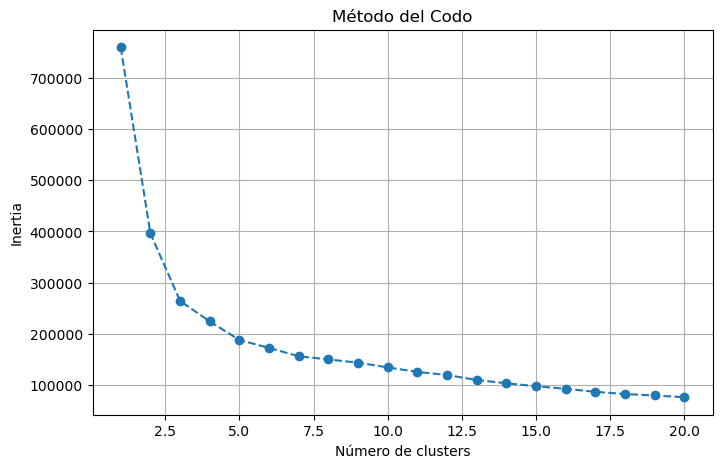

In [75]:
# Calcular la inertia para diferentes números de clusters
inertia = []
for k in range(1, 21):  # Probar de 1 a 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_data)  # Usa los datos reducidos por PCA
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 21), inertia, marker='o', linestyle='--')
plt.xlabel('Número de clusters')
plt.ylabel('Inertia')
plt.title('Método del Codo')
plt.grid()
plt.show()

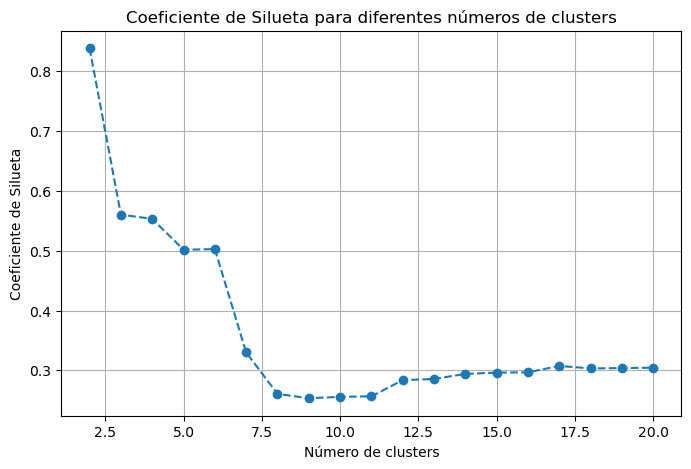

In [76]:
from sklearn.metrics import silhouette_score

# Calcular el coeficiente de silueta para diferentes números de clusters
silhouette_scores = []
for k in range(2, 21):  # Probar de 2 a 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_data)
    score = silhouette_score(pca_data, kmeans.labels_)
    silhouette_scores.append(score)

# Graficar el coeficiente de silueta
plt.figure(figsize=(8, 5))
plt.plot(range(2, 21), silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Número de clusters')
plt.ylabel('Coeficiente de Silueta')
plt.title('Coeficiente de Silueta para diferentes números de clusters')
plt.grid()
plt.show()

In [77]:
# Aplicar el algoritmo K-Means para clustering
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(df_analysis)

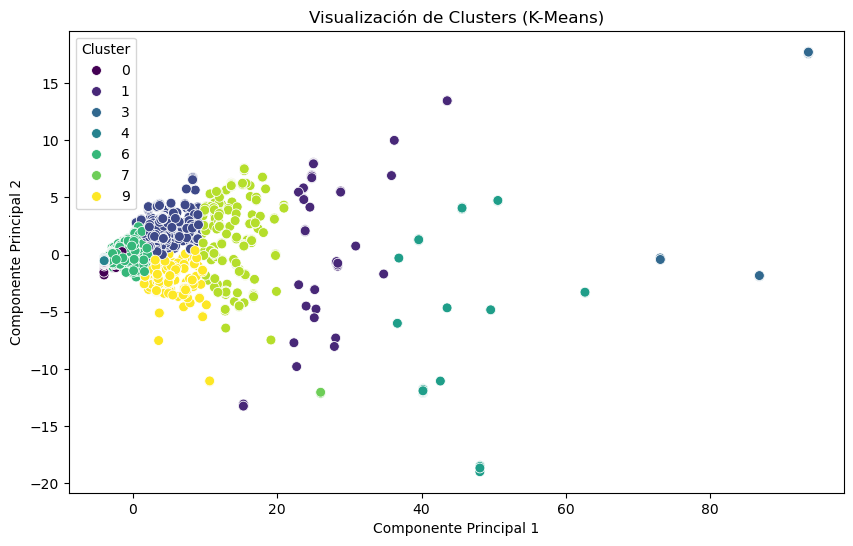

In [78]:

# Agregar los clusters al DataFrame original
df_analysis['Cluster'] = clusters

# Visualizar los clusters en el espacio reducido por PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=clusters, palette="viridis", s=50)
plt.title("Visualización de Clusters (K-Means)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster")
plt.show()

In [79]:
import plotly.express as px

# Crear un DataFrame con los datos de PCA y clusters
df_pca = pd.DataFrame(pca_data[:,:3], columns=['PC1', 'PC2', 'PC3'])  # Asegúrate de que pca_data tenga al menos 3 componentes
df_pca['Cluster'] = clusters  # Agregar los clusters al DataFrame

# Graficar en 3D con plotly
fig = px.scatter_3d(
    df_pca,
    x='PC1', y='PC2', z='PC3',  # Ejes del gráfico
    color='Cluster',            # Colorear por cluster
    title="Visualización de Clusters en 3D (K-Means)",
    opacity=0.3,                # Transparencia de los puntos
    size_max=1,                 # Tamaño máximo de los puntos
    symbol_sequence=['circle'], # Usar círculos como símbolo
    color_continuous_scale='Viridis'  # Paleta de colores
)

# Ajustar el tamaño del gráfico
fig.update_layout(
    width=600,  # Ancho del gráfico
    height=600   # Alto del gráfico
)

# Mostrar el gráfico interactivo
fig.show()

In [80]:
# Mostrar el tamaño de cada cluster
cluster_sizes = df_analysis['Cluster'].value_counts()
print("\nTamaño de cada cluster:")
cluster_sizes


Tamaño de cada cluster:


Cluster
4    2859
6    2278
0    1216
2    1011
9     413
8     309
5     110
1      71
3      20
7       2
Name: count, dtype: int64

In [81]:
# Calcular las características promedio de cada cluster
numeric_columns = df_analysis.select_dtypes('number')
cluster_means = numeric_columns.groupby(df_analysis['Cluster']).mean()
cluster_means.T

Cluster            0         1         2          3         4         5  \
TVIVHAB    -0.474706  3.358171  0.654690  10.535626 -0.487494  4.608849   
P_60YMAS   -0.497737  3.038632  0.568671   8.198284 -0.515479  4.704044   
P_18YMAS   -0.398447  2.544571  0.416098   8.708733 -0.408442  4.418118   
VPH_TINACO -0.507538  3.379599  0.752003   8.561807 -0.521945  4.618679   
VPH_CEL    -0.474621  3.385486  0.677030  10.549804 -0.487568  4.552644   
...              ...       ...       ...        ...       ...       ...   
VPH_MOTO   -0.414687  2.981580  0.643730   9.804933 -0.418484  4.205538   
VPH_TV     -0.472200  3.341752  0.645116  10.553132 -0.485102  4.656555   
VIVPAR_UT  -0.276037  0.527692  1.026660   1.749000 -0.278091  0.768908   
VPH_S_ELEC  0.000000  0.000000  0.000000   0.000000  0.000000  0.000000   
Cluster     0.000000  1.000000  2.000000   3.000000  4.000000  5.000000   

Cluster            6          7         8         9  
TVIVHAB    -0.163932  -0.459197  1.748112  0.453191  
P_60YMAS   -0.109590   7.731915  1.836182  0.662770  
P_18YMAS   -0.147837  34.073460  1.396939  0.551362  
VPH_TINACO -0.156021  -0.522550  1.901553  0.481282  
VPH_CEL    -0.163562  -0.488120  1.742927  0.410332  
...              ...        ...       ...       ...  
VPH_MOTO   -0.234046  -0.418484  1.666613  0.480646  
VPH_TV     -0.163419  -0.485657  1.730245  0.452632  
VIVPAR_UT  -0.077489  -0.280233  0.573123 -0.155613  
VPH_S_ELEC  0.000000   0.000000  0.000000  0.000000  
Cluster     6.000000   7.000000  8.000000  9.000000  

[99 rows x 10 columns]

In [82]:
df_analysis.columns

Index(['TVIVHAB', 'P_60YMAS', 'P_18YMAS', 'VPH_TINACO', 'VPH_CEL',
       'VIVPAR_HAB', 'VPH_NDEAED', 'P_6A11_M', 'POB65_MAS', 'P_3A5_F',
       'P18YM_PB_M', 'PHOGJEF_M', 'VIVPARH_CV', 'lote_m2', 'P_18A24',
       'P_18YMAS_F', 'VPH_SINLTC', 'VPH_AGUAFV', 'P_8A14_M', 'P_12A14_M',
       'VPH_REFRI', 'P_3A5_M', 'VPH_SINCINT', 'VPH_HMICRO', 'PHOGJEF_F',
       'VPH_NDACMM', 'POBHOG', 'P18YM_PB_F', 'VPH_DSADMA', 'VPH_NODREN',
       'VPH_LETR', 'VIVPAR_DES', 'VPH_3YMASC', 'PROM_OCUP', 'VPH_SPMVPI',
       'POBFEM', 'VPH_AEASP', 'VIVTOT', 'P_60YMAS_M', 'P_6A11', 'recamaras',
       'P_18A24_F', 'TVIVPAR', 'VPH_CVJ', 'P_60YMAS_F', 'OCUPVIVPAR',
       'VPH_AGUADV', 'VPH_CISTER', 'VPH_2YMASD', 'P_0A2', 'VPH_SINRTV',
       'PRO_OCUP_C', 'P_6A11_F', 'P_0A2_F', 'P_15A17_F', 'HOGJEF_F', 'P_15A17',
       'HOGJEF_M', 'VPH_DRENAJ', 'VPH_SINTIC', 'VPH_1DOR', 'VPH_EXCSA',
       'VPH_C_ELEC', 'baños', 'POBTOT', 'P_8A14', 'VPH_PC', 'P_0A2_M',
       'VPH_BICI', 'P_3A5', 'es_amueblado', 'VPH_RADIO',

In [83]:
loadings = pd.DataFrame(
            pca.components_.T,
            columns=[f'PC{i+1}' for i in range(pca.n_components_)],
            index=df_analysis.drop('Cluster',axis =1).columns
        )

In [84]:
feature_importance_pca = np.sum(
            loadings.abs() * pca.explained_variance_ratio_, axis=1
        )
feature_importance_pca = feature_importance_pca.sort_values(ascending=False)

In [85]:
pd.set_option('display.max_rows', None)  # Mostrar todas las filas
feature_importance_pca.sort_values(ascending=False, inplace = True)

In [86]:
feature_importance_pca

VPH_STVP           9.421755e-02
VPH_AUTOM          9.417827e-02
VPH_CVJ            9.400149e-02
VPH_NDACMM         9.372003e-02
TVIVPAR            9.355326e-02
VIVTOT             9.343062e-02
P18YM_PB_M         9.325117e-02
VPH_3YMASC         9.306021e-02
VPH_HMICRO         9.300109e-02
P18YM_PB_F         9.285293e-02
P18YM_PB           9.274225e-02
VPH_TELEF          9.265673e-02
P_18A24            9.265208e-02
VPH_PC             9.264568e-02
P_6A11             9.263569e-02
VPH_INTER          9.260408e-02
P_8A14             9.256360e-02
VPH_1DOR           9.229452e-02
VPH_LAVAD          9.212769e-02
P_8A14_F           9.212750e-02
VPH_2YMASD         9.206911e-02
P_8A14_M           9.198339e-02
P_12A14            9.195939e-02
VPH_RADIO          9.194797e-02
VPH_CEL            9.184212e-02
PHOGJEF_M          9.177282e-02
P_6A11_F           9.174346e-02
P_3A5              9.171625e-02
VPH_REFRI          9.169457e-02
HOGJEF_F           9.166762e-02
P_6A11_M           9.165259e-02
P_12A14_

In [87]:
feature_importance_pca.index

Index(['VPH_STVP', 'VPH_AUTOM', 'VPH_CVJ', 'VPH_NDACMM', 'TVIVPAR', 'VIVTOT',
       'P18YM_PB_M', 'VPH_3YMASC', 'VPH_HMICRO', 'P18YM_PB_F', 'P18YM_PB',
       'VPH_TELEF', 'P_18A24', 'VPH_PC', 'P_6A11', 'VPH_INTER', 'P_8A14',
       'VPH_1DOR', 'VPH_LAVAD', 'P_8A14_F', 'VPH_2YMASD', 'P_8A14_M',
       'P_12A14', 'VPH_RADIO', 'VPH_CEL', 'PHOGJEF_M', 'P_6A11_F', 'P_3A5',
       'VPH_REFRI', 'HOGJEF_F', 'P_6A11_M', 'P_12A14_M', 'VPH_TV', 'POBTOT',
       'VPH_DSADMA', 'VPH_C_SERV', 'VPH_EXCSA', 'VPH_DRENAJ', 'VPH_C_ELEC',
       'VIVPARH_CV', 'VPH_AGUADV', 'TVIVPARHAB', 'TOTHOG', 'TVIVHAB',
       'VPH_AEASP', 'HOGJEF_M', 'VPH_TINACO', 'VPH_SINCINT', 'P_15A17',
       'VPH_SPMVPI', 'P_3A5_F', 'P_12A14_F', 'P_18A24_M', 'POBHOG',
       'OCUPVIVPAR', 'P_18A24_F', 'POBFEM', 'P_15A49_F', 'P_0A2', 'PHOGJEF_F',
       'P_15A17_F', 'VPH_2CUART', 'P_18YMAS_F', 'P_15A17_M', 'VIVPAR_HAB',
       'VPH_CISTER', 'P_0A2_F', 'P_3A5_M', 'P_60YMAS', 'P_60YMAS_F',
       'VPH_MOTO', 'P_18YMAS', 'POB65_MAS

In [88]:
#random_position = feature_importance_pca.index.get_loc('random')
# Quedarse solo con las features antes de 'random'
#filtered_features = feature_importance_pca.iloc[:random_position]
        

In [89]:
#filtered_features.index

In [90]:
#final_features = list(filtered_features.index)
final_features = list(feature_importance_pca.index)

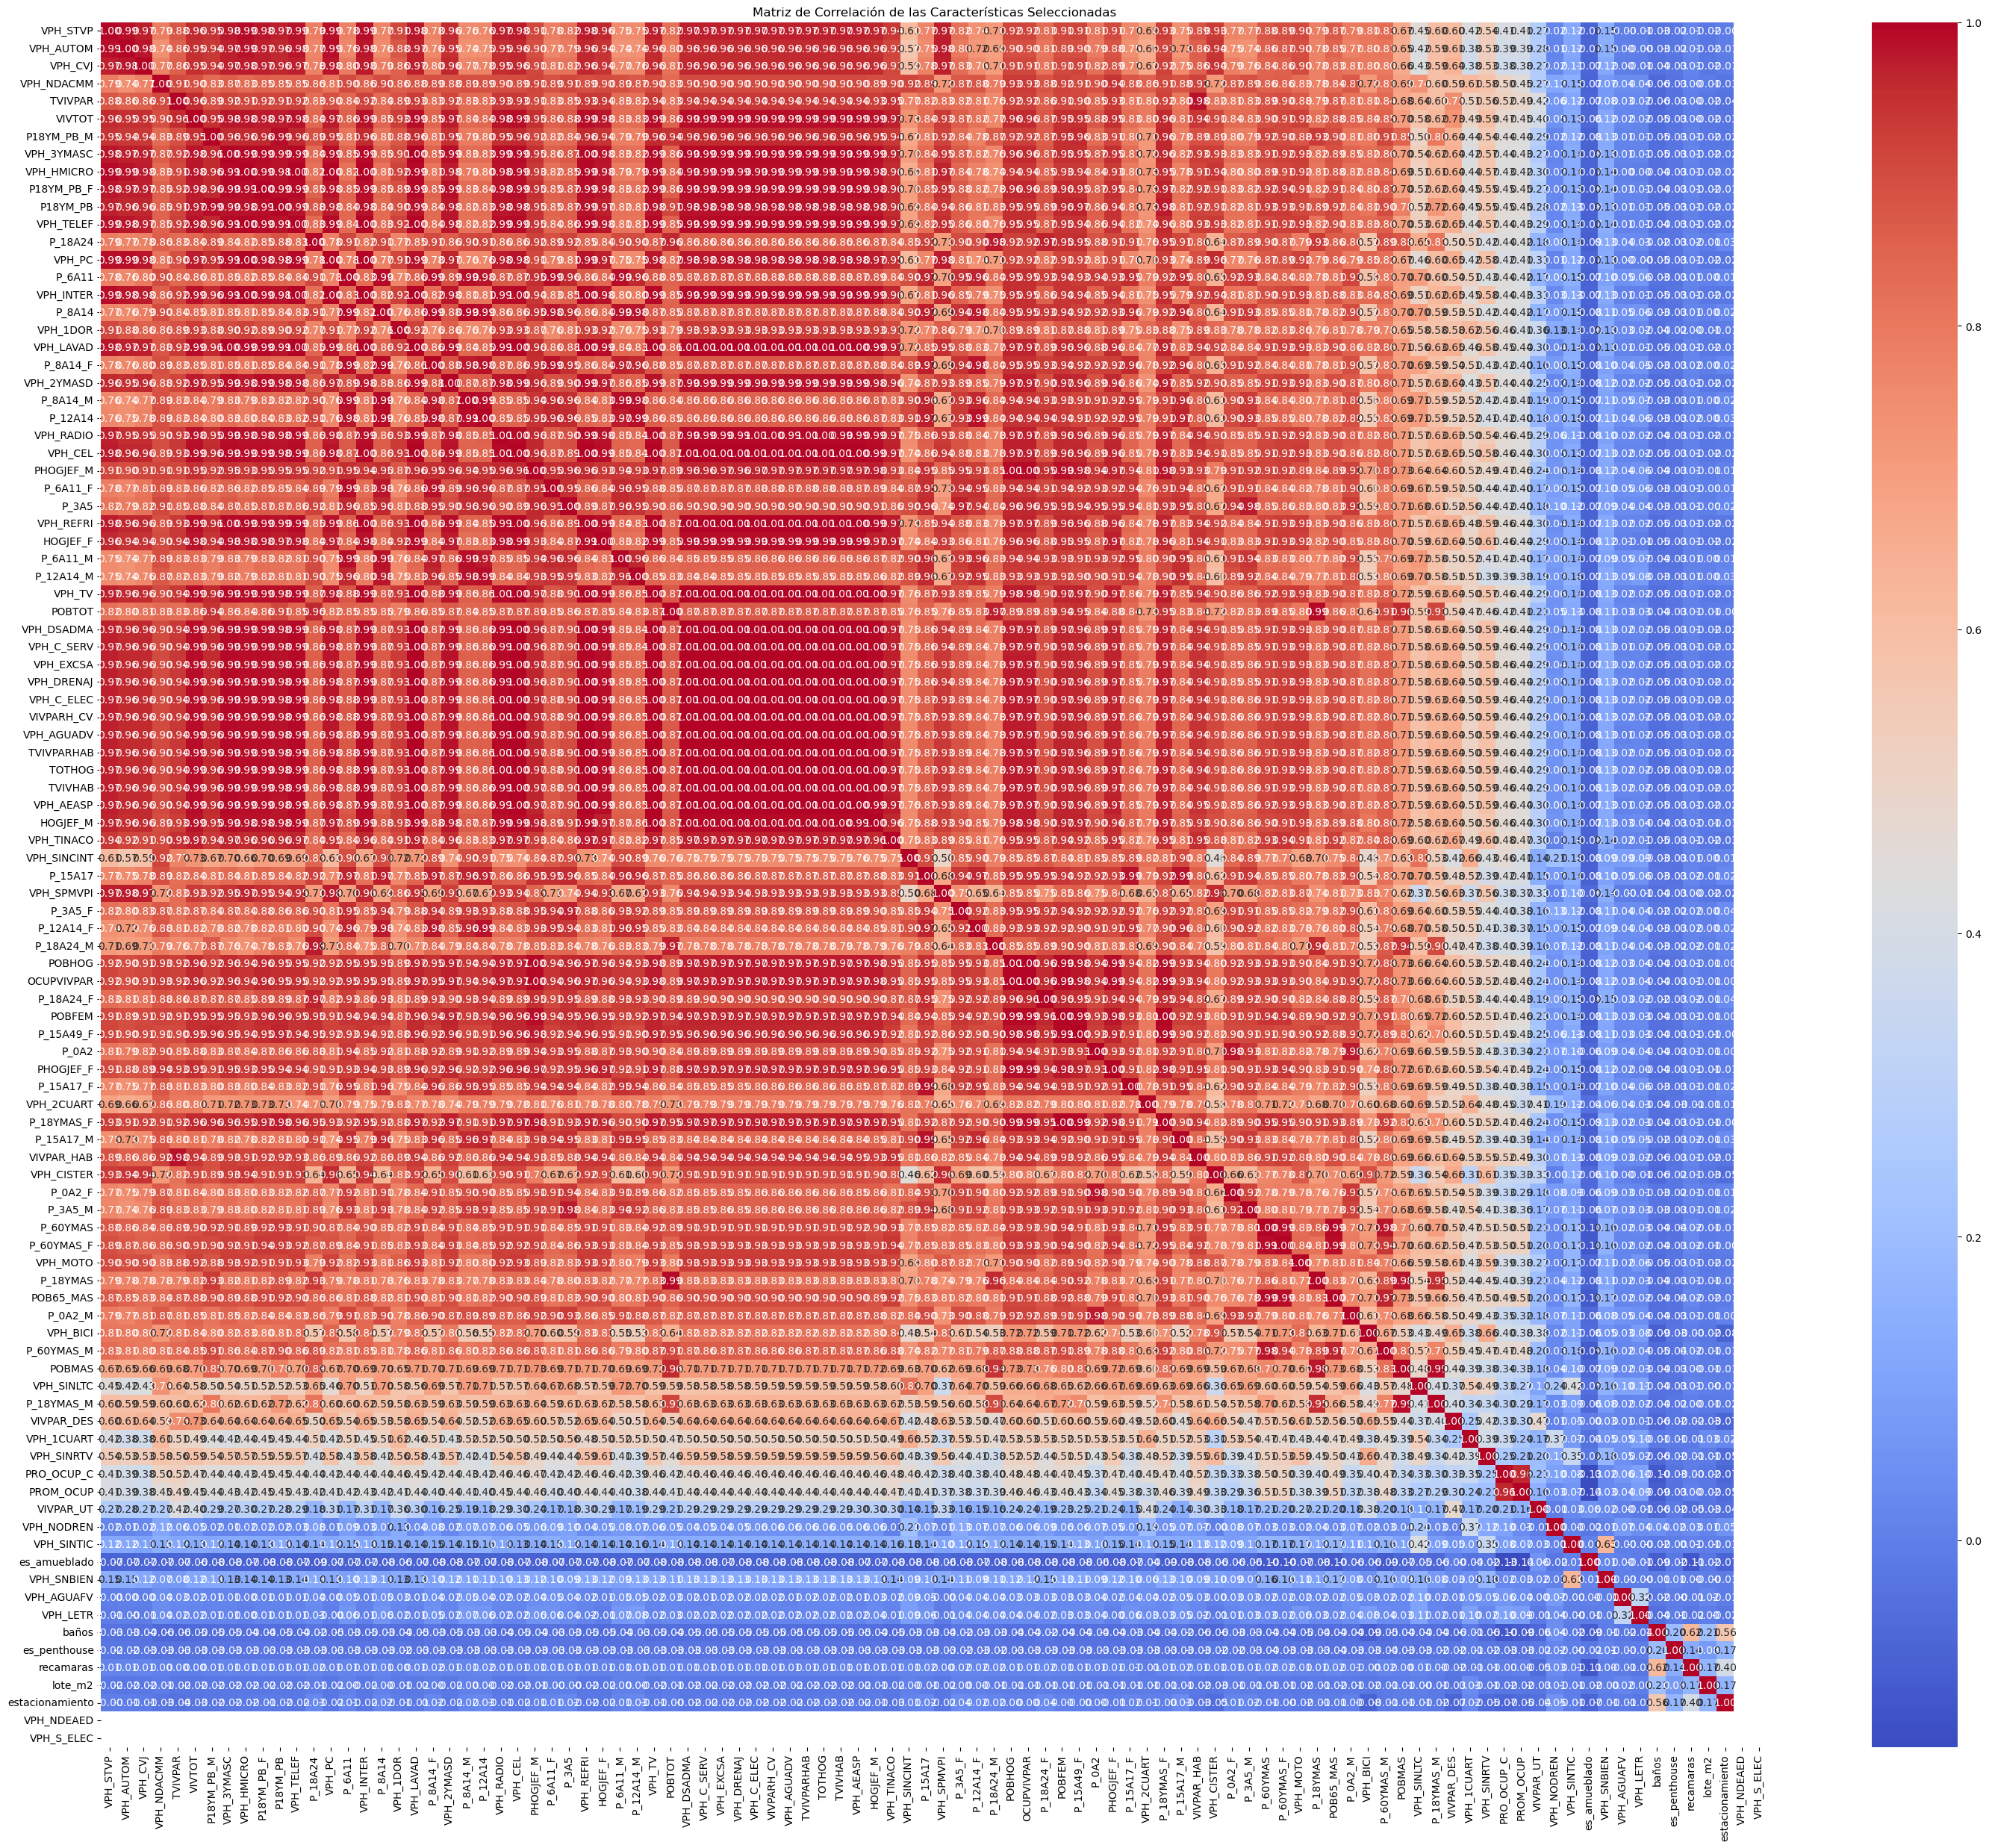

In [91]:
# Calcular la matriz de correlación para las características seleccionadas
correlation_matrix = df[final_features].corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(36, 30))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matriz de Correlación de las Características Seleccionadas")
plt.show()

In [92]:
# Establecer un umbral para considerar alta correlación
correlation_threshold = 0.60

# Identificar pares de características altamente correlacionadas
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

print(f"Pares de características altamente correlacionadas (umbral > {correlation_threshold}):")
high_corr_pairs

Pares de características altamente correlacionadas (umbral > 0.6):


[('VPH_AUTOM', 'VPH_STVP'),
 ('VPH_CVJ', 'VPH_STVP'),
 ('VPH_CVJ', 'VPH_AUTOM'),
 ('VPH_NDACMM', 'VPH_STVP'),
 ('VPH_NDACMM', 'VPH_AUTOM'),
 ('VPH_NDACMM', 'VPH_CVJ'),
 ('TVIVPAR', 'VPH_STVP'),
 ('TVIVPAR', 'VPH_AUTOM'),
 ('TVIVPAR', 'VPH_CVJ'),
 ('TVIVPAR', 'VPH_NDACMM'),
 ('VIVTOT', 'VPH_STVP'),
 ('VIVTOT', 'VPH_AUTOM'),
 ('VIVTOT', 'VPH_CVJ'),
 ('VIVTOT', 'VPH_NDACMM'),
 ('VIVTOT', 'TVIVPAR'),
 ('P18YM_PB_M', 'VPH_STVP'),
 ('P18YM_PB_M', 'VPH_AUTOM'),
 ('P18YM_PB_M', 'VPH_CVJ'),
 ('P18YM_PB_M', 'VPH_NDACMM'),
 ('P18YM_PB_M', 'TVIVPAR'),
 ('P18YM_PB_M', 'VIVTOT'),
 ('VPH_3YMASC', 'VPH_STVP'),
 ('VPH_3YMASC', 'VPH_AUTOM'),
 ('VPH_3YMASC', 'VPH_CVJ'),
 ('VPH_3YMASC', 'VPH_NDACMM'),
 ('VPH_3YMASC', 'TVIVPAR'),
 ('VPH_3YMASC', 'VIVTOT'),
 ('VPH_3YMASC', 'P18YM_PB_M'),
 ('VPH_HMICRO', 'VPH_STVP'),
 ('VPH_HMICRO', 'VPH_AUTOM'),
 ('VPH_HMICRO', 'VPH_CVJ'),
 ('VPH_HMICRO', 'VPH_NDACMM'),
 ('VPH_HMICRO', 'TVIVPAR'),
 ('VPH_HMICRO', 'VIVTOT'),
 ('VPH_HMICRO', 'P18YM_PB_M'),
 ('VPH_HMICRO', 'VP

In [93]:
# Crear un conjunto para almacenar las características a eliminar
features_to_remove = set()

# Para cada par de características correlacionadas, eliminar la menos importante según PCA
for feature1, feature2 in high_corr_pairs:
    if feature_importance_pca[feature1] < feature_importance_pca[feature2]:
        features_to_remove.add(feature1)
    else:
        features_to_remove.add(feature2)

# Filtrar las características finales eliminando las correlacionadas menos importantes
final_features_filtered = [feature for feature in final_features if feature not in features_to_remove]

print(f"Características finales después de eliminar correlacionadas: {len(final_features_filtered)}")
final_features_filtered

Características finales después de eliminar correlacionadas: 14


['VPH_STVP',
 'PRO_OCUP_C',
 'VIVPAR_UT',
 'VPH_NODREN',
 'VPH_SINTIC',
 'es_amueblado',
 'VPH_AGUAFV',
 'VPH_LETR',
 'baños',
 'es_penthouse',
 'lote_m2',
 'estacionamiento',
 'VPH_NDEAED',
 'VPH_S_ELEC']

In [94]:
final_features = final_features_filtered.copy()

In [95]:
df.isnull().sum().sort_values(ascending=False)[:10]

quarter       8260
CVEVIAL3       117
CVESEG3        117
TIPOVR3        117
NOMREF3        117
road            87
precio_mxn       0
key              0
ENTIDAD_fm       0
MUN_fm           0
dtype: int64

In [96]:
# Guardar el DataFrame procesado y la lista de características finales
import json

processed_data_path = '../../data/processed/final_processed_data.parquet'
features_path = '../../data/processed/final_features.json'

# Asegurarse de que las columnas de características finales existen en el df
final_cols_to_save = final_features + ['precio_mxn'] + [col for col in df.columns if col.startswith(('municipio_', 'colonia_top10_'))]
df_to_save = df[final_cols_to_save]

df_to_save.to_parquet(processed_data_path)

with open(features_path, 'w') as f:
    json.dump(final_features, f)

print(f"DataFrame procesado guardado en: {processed_data_path}")
print(f"Características finales guardadas en: {features_path}")

DataFrame procesado guardado en: ../../data/processed/final_processed_data.parquet
Características finales guardadas en: ../../data/processed/final_features.json


In [97]:
final_features

['VPH_STVP',
 'PRO_OCUP_C',
 'VIVPAR_UT',
 'VPH_NODREN',
 'VPH_SINTIC',
 'es_amueblado',
 'VPH_AGUAFV',
 'VPH_LETR',
 'baños',
 'es_penthouse',
 'lote_m2',
 'estacionamiento',
 'VPH_NDEAED',
 'VPH_S_ELEC']